## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from google.colab import drive
# drive.mount('/content/drive')pip
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

from sklearnex import patch_sklearn

patch_sklearn()

import shap
import time

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## Dataset Load

In [3]:
# data_path = '/content/drive/My Drive/Thesis/heart.csv'
data_path = 'CVD_dataset.csv'

In [4]:
data = pd.read_csv(data_path)
data.head()

,General_Health,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,Cardio_Disease
0,Poor,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,No
1,Very Good,No,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,Yes
2,Very Good,Yes,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,No
3,Poor,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,Yes
4,Good,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Exercise                      308854 non-null  object 
 2   Skin_Cancer                   308854 non-null  object 
 3   Other_Cancer                  308854 non-null  object 
 4   Depression                    308854 non-null  object 
 5   Diabetes                      308854 non-null  object 
 6   Arthritis                     308854 non-null  object 
 7   Sex                           308854 non-null  object 
 8   Age_Category                  308854 non-null  object 
 9   Height_(cm)                   308854 non-null  int64  
 10  Weight_(kg)                   308854 non-null  float64
 11  BMI                           308854 non-null  float64
 12  Smoking_History               308854 non-nul

In [6]:
data.isnull().sum() # finding is there any null data

General_Health                  0
Exercise                        0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
Cardio_Disease                  0
dtype: int64

In [7]:
data.nunique() # differnet value in a column

General_Health                     5
Exercise                           2
Skin_Cancer                        2
Other_Cancer                       2
Depression                         2
Diabetes                           4
Arthritis                          2
Sex                                2
Age_Category                      13
Height_(cm)                       99
Weight_(kg)                      525
BMI                             3654
Smoking_History                    2
Alcohol_Consumption               31
Fruit_Consumption                 77
Green_Vegetables_Consumption      75
Cardio_Disease                     2
dtype: int64

In [8]:
data.duplicated().sum() # finding is there any duplicate data

np.int64(784)

In [9]:
data_without_duplicates = data.drop_duplicates(keep='first') # delete duplicate values and keep the first one
data_without_duplicates.info() # new data info after merging duplicate data

<class 'pandas.core.frame.DataFrame'>
Index: 308070 entries, 0 to 308853
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308070 non-null  object 
 1   Exercise                      308070 non-null  object 
 2   Skin_Cancer                   308070 non-null  object 
 3   Other_Cancer                  308070 non-null  object 
 4   Depression                    308070 non-null  object 
 5   Diabetes                      308070 non-null  object 
 6   Arthritis                     308070 non-null  object 
 7   Sex                           308070 non-null  object 
 8   Age_Category                  308070 non-null  object 
 9   Height_(cm)                   308070 non-null  int64  
 10  Weight_(kg)                   308070 non-null  float64
 11  BMI                           308070 non-null  float64
 12  Smoking_History               308070 non-null  ob

In [10]:
data_count = data_without_duplicates.copy()

In [11]:
data_count

,General_Health,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,Cardio_Disease
0,Poor,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,No
1,Very Good,No,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,Yes
2,Very Good,Yes,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,No
3,Poor,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,Yes
4,Good,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,Very Good,Yes,No,No,No,No,No,Male,25-29,168,81.65,29.05,No,4,30,8,No
308850,Fair,Yes,No,No,No,Yes,No,Male,65-69,180,69.85,21.48,No,8,15,60,No
308851,Very Good,Yes,No,No,Yes,"Yes, but female told only during pregnancy",No,Female,30-34,157,61.23,24.69,Yes,4,40,8,No
308852,Very Good,Yes,No,No,No,No,No,Male,65-69,183,79.38,23.73,No,3,30,12,No


## Encoding using LabelEncoder

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [13]:
for col in data_without_duplicates.columns:
    if data_without_duplicates[col].dtype == 'object':
        data_without_duplicates[col] = encoder.fit_transform(data_without_duplicates[col])

data_without_duplicates

,General_Health,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,Cardio_Disease
0,3,0,0,0,0,0,1,0,10,150,32.66,14.54,1,0,30,16,0
1,4,0,0,0,0,2,0,0,10,165,77.11,28.29,0,0,30,0,1
2,4,1,0,0,0,2,0,0,8,163,88.45,33.47,0,4,12,3,0
3,3,1,0,0,0,2,0,1,11,180,93.44,28.73,0,0,30,30,1
4,2,0,0,0,0,0,0,1,12,191,88.45,24.37,1,0,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,4,1,0,0,0,0,0,1,1,168,81.65,29.05,0,4,30,8,0
308850,1,1,0,0,0,2,0,1,9,180,69.85,21.48,0,8,15,60,0
308851,4,1,0,0,1,3,0,0,2,157,61.23,24.69,1,4,40,8,0
308852,4,1,0,0,0,0,0,1,9,183,79.38,23.73,0,3,30,12,0


Index(['General_Health', 'Exercise', 'Skin_Cancer', 'Other_Cancer',
       'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category',
       'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'Cardio_Disease'],
      dtype='object')
Total numeric columns: 17


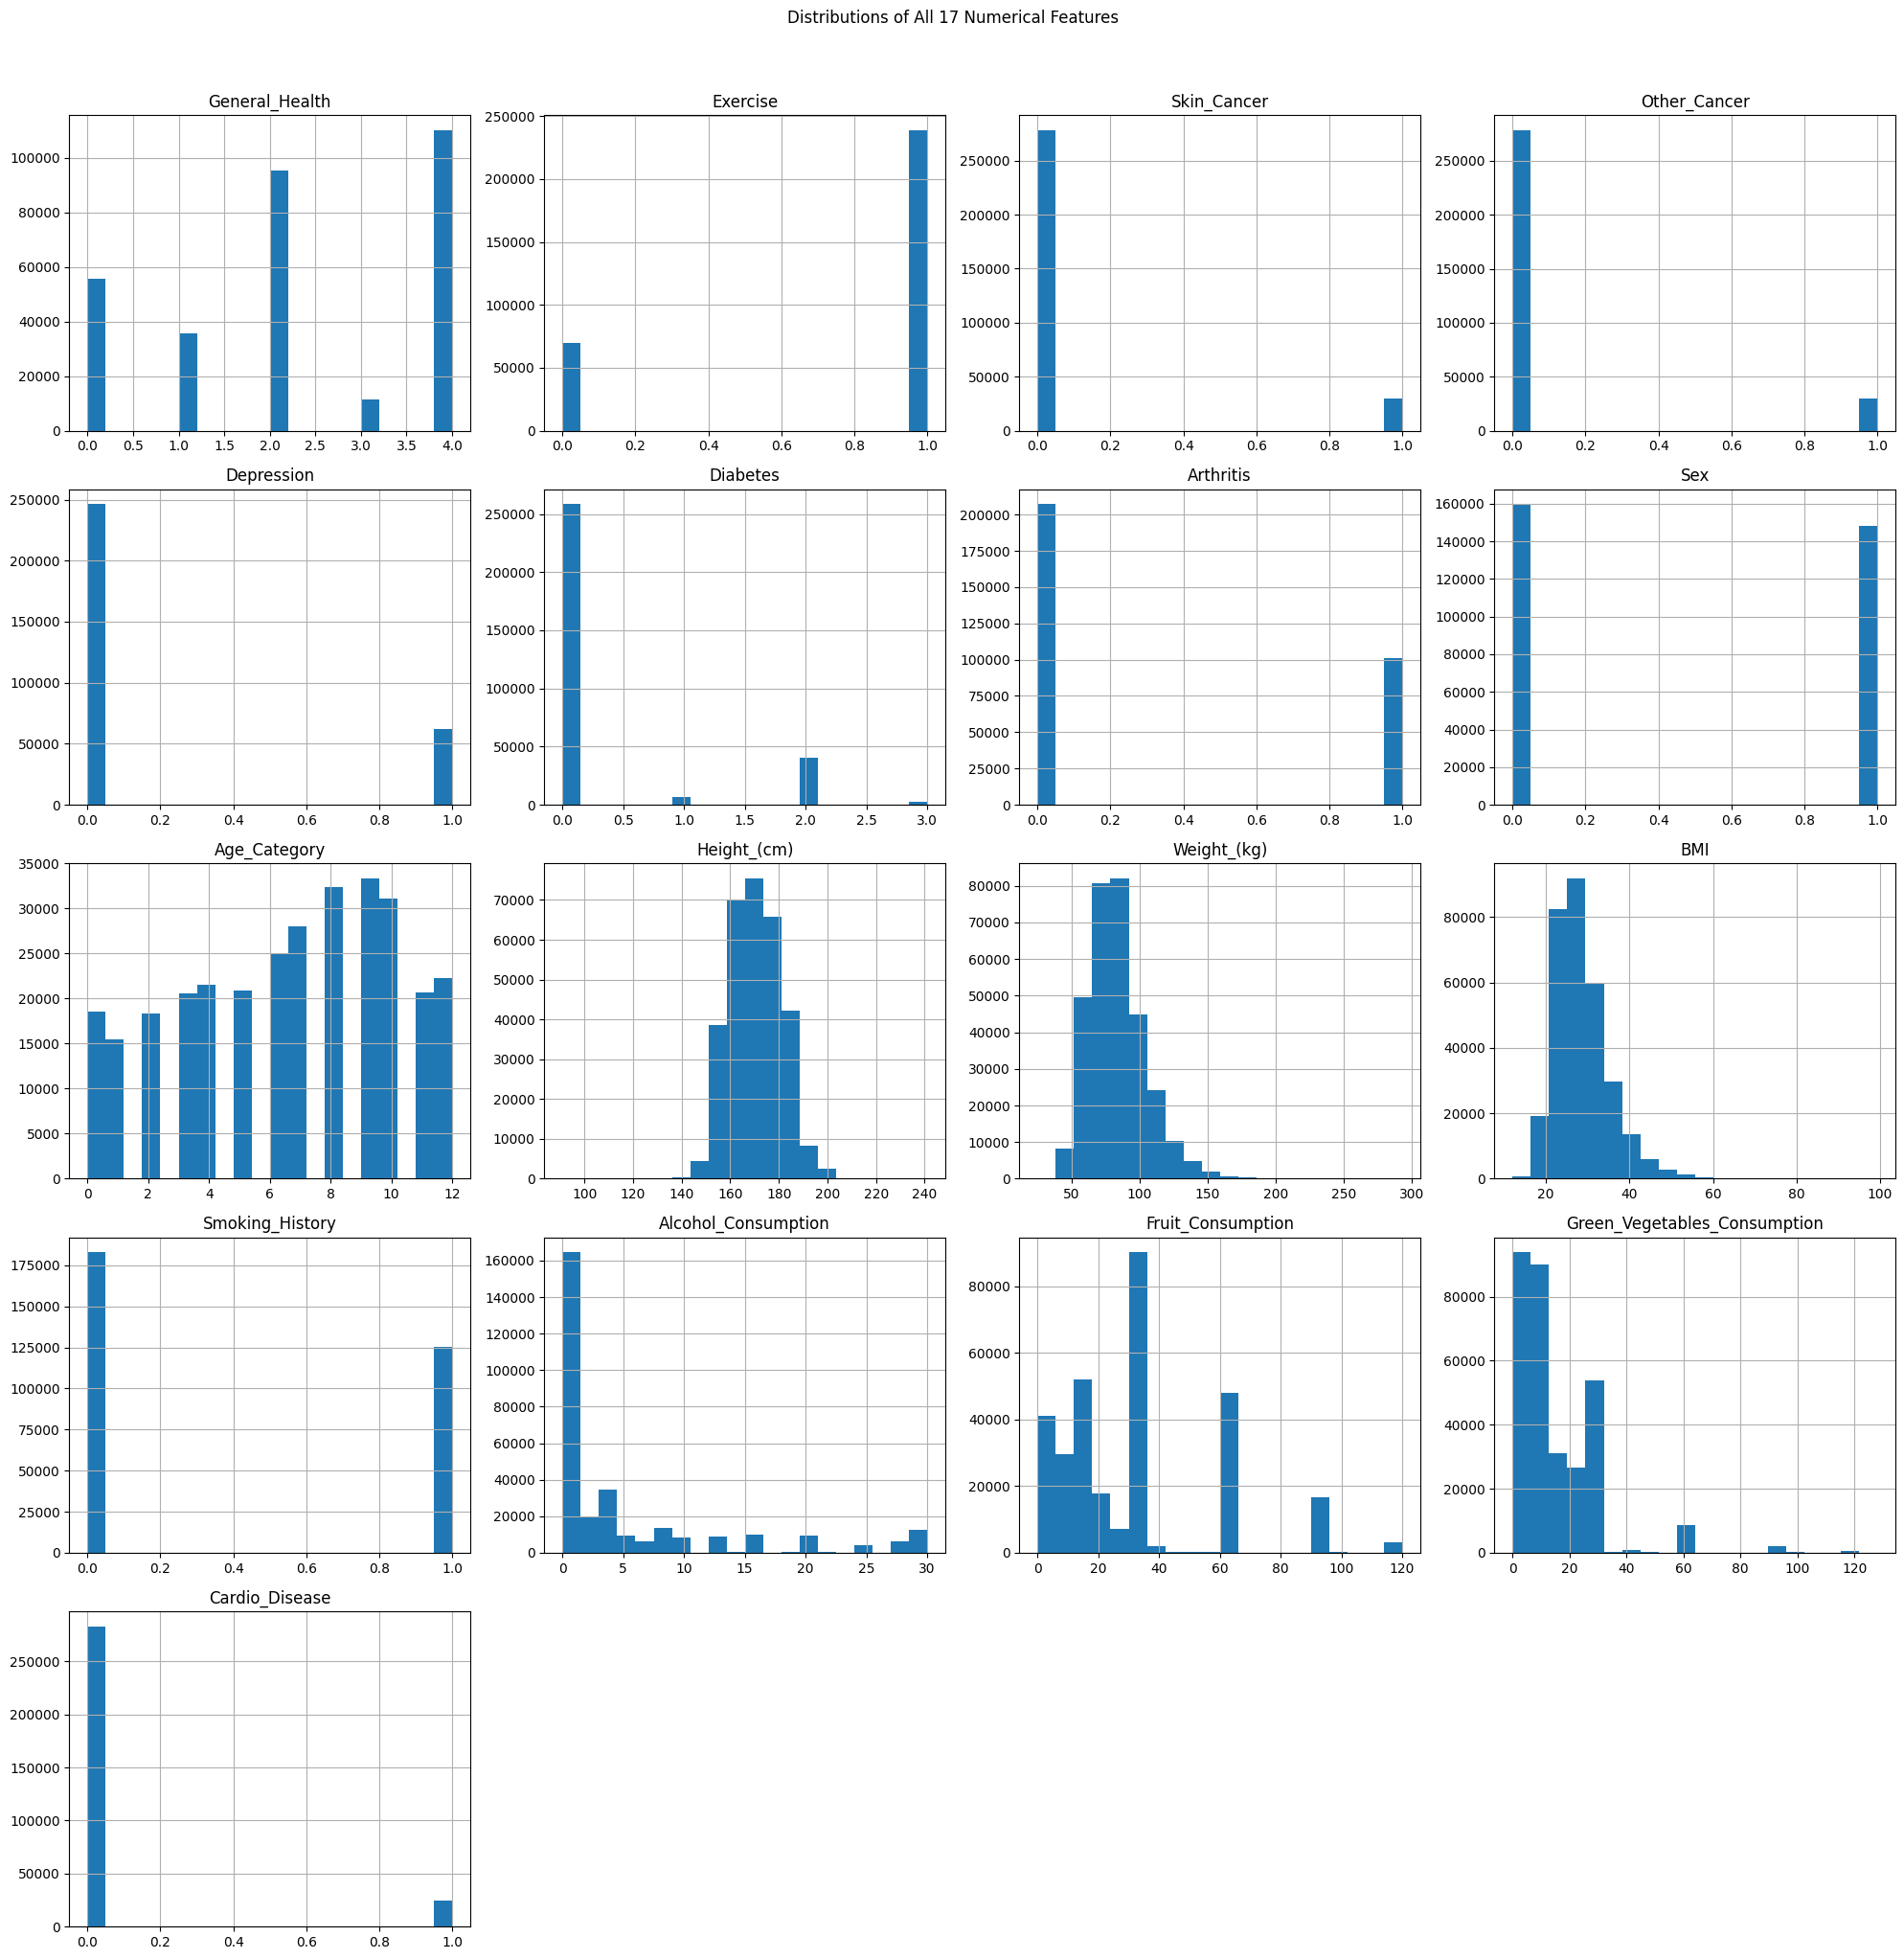

In [14]:
num_columns = data_without_duplicates.select_dtypes(include=[np.number]).columns
print(num_columns)
print("Total numeric columns:", len(num_columns))
cols = 4
rows = math.ceil(len(num_columns) / cols)

# Plot
data_without_duplicates[num_columns].hist(
    bins=20,
    figsize=(20, rows * 4),   
    layout=(rows, cols)       
)
plt.suptitle('Distributions of All 17 Numerical Features', y=1.02)
plt.tight_layout()
plt.show()



## Checking Duplicates


In [15]:
data_without_duplicates.columns

Index(['General_Health', 'Exercise', 'Skin_Cancer', 'Other_Cancer',
       'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category',
       'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'Cardio_Disease'],
      dtype='object')

In [16]:
X = data_without_duplicates.drop('Cardio_Disease', axis=1) # use all features except target column
y = data_without_duplicates['Cardio_Disease'] # target data

In [17]:
print(data.dtypes)

General_Health                   object
Exercise                         object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64
Fruit_Consumption                 int64
Green_Vegetables_Consumption      int64
Cardio_Disease                   object
dtype: object


In [18]:
print(data_count)
data['Cardio_Disease'].value_counts()

       General_Health Exercise Skin_Cancer Other_Cancer Depression  \
0                Poor       No          No           No         No   
1           Very Good       No          No           No         No   
2           Very Good      Yes          No           No         No   
3                Poor      Yes          No           No         No   
4                Good       No          No           No         No   
...               ...      ...         ...          ...        ...   
308849      Very Good      Yes          No           No         No   
308850           Fair      Yes          No           No         No   
308851      Very Good      Yes          No           No        Yes   
308852      Very Good      Yes          No           No         No   
308853      Excellent      Yes          No           No         No   

                                          Diabetes Arthritis     Sex  \
0                                               No       Yes  Female   
1              

Cardio_Disease
No     283883
Yes     24971
Name: count, dtype: int64

## Showing the risk of having Cardiovascular Diseases depending on the Gender

In [19]:
data_count['Sex'] = data_count['Sex'].replace({
    0 : "Female", 1 : "Male"
})

gender_count = data_count['Sex'].value_counts().sort_values()
print('Number of Total Female and Male')
gender_count

Number of Total Female and Male


Sex
Male      148332
Female    159738
Name: count, dtype: int64

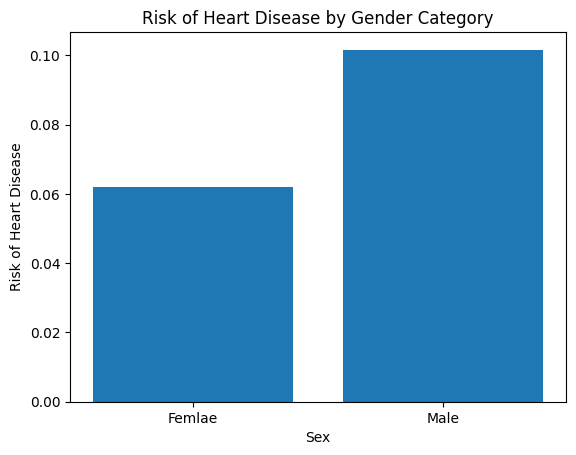

In [20]:
gender_group = data_without_duplicates.groupby('Sex')
risk_by_gender = gender_group['Cardio_Disease'].mean()
gender_group_names = {
   0 : "Femlae", 1 : "Male"
}
plt.bar(gender_group_names.values(), risk_by_gender.values)
plt.xlabel('Sex')
plt.ylabel('Risk of Heart Disease')
plt.title('Risk of Heart Disease by Gender Category')
plt.xticks(rotation=0)
plt.show()

## The chances of having  Cardiovascular diseases of differnt age category

In [21]:
data_count['Age_Category'] = data_count['Age_Category'].replace({
     0: "18 to 24",
    1: "25 to 29",
    2: "30 to 34",
    3: "35 to 39",
    4: "40 to 44",
    5: "45 to 49",
    6: "50 to 54",
    7: "55 to 59",
    8: "60 to 64",
    9: "65 to 69",
    10: "70 to 74",
    11: "75 to 79",
    12: "80 or older"
})
age_count = data_count['Age_Category'].value_counts().sort_values()
print('Number of People According to their Age (Sorted)')
age_count

Number of People According to their Age (Sorted)


Age_Category
25-29    15456
30-34    18359
18-24    18570
35-39    20554
75-79    20676
45-49    20903
40-44    21532
80+      22227
50-54    25024
55-59    28000
70-74    31063
60-64    32350
65-69    33356
Name: count, dtype: int64

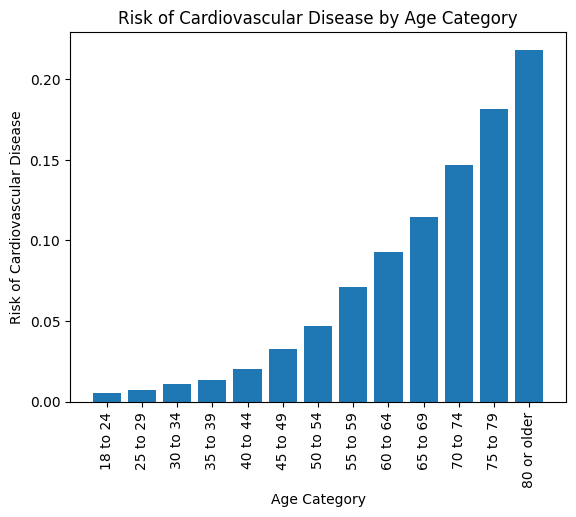

In [22]:
age_group = data_without_duplicates.groupby('Age_Category')
risk_by_age = age_group['Cardio_Disease'].mean()
age_group_names = {
    0: "18 to 24",
    1: "25 to 29",
    2: "30 to 34",
    3: "35 to 39",
    4: "40 to 44",
    5: "45 to 49",
    6: "50 to 54",
    7: "55 to 59",
    8: "60 to 64",
    9: "65 to 69",
    10: "70 to 74",
    11: "75 to 79",
    12: "80 or older",
}
plt.bar(age_group_names.values(), risk_by_age.values)
plt.xlabel('Age Category')
plt.ylabel('Risk of Cardiovascular Disease')
plt.title('Risk of Cardiovascular Disease by Age Category')
plt.xticks(rotation=90)
plt.show()

## The chances of having Cardiovascular diseases of differnt General Health

In [23]:
## The chances of having heart diseases of differnt General Health
data_count['General_Health'] = data_count['General_Health'].replace({
    0: "Excellent",
    1: "Fair",
    2: "Good",
    3: "Poor",
    4: "Very Good"
})

general_health_count = data_count['General_Health'].value_counts().sort_values()
print('Number of People According to their General Health (Sorted)')
general_health_count

Number of People According to their General Health (Sorted)


General_Health
Poor          11331
Fair          35800
Excellent     55710
Good          95226
Very Good    110003
Name: count, dtype: int64

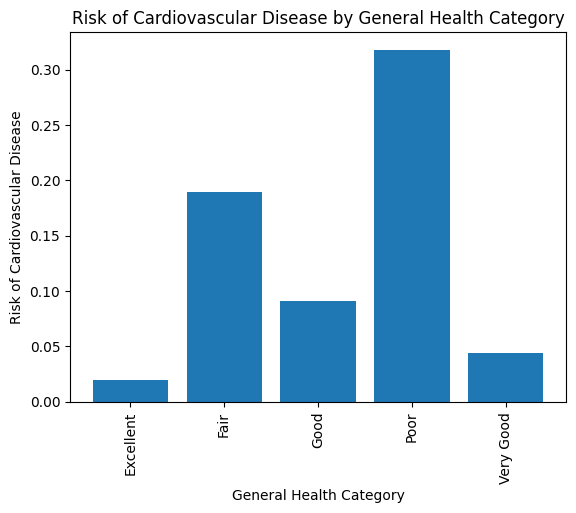

In [24]:
general_health_group = data_without_duplicates.groupby('General_Health')
risk_by_general_health = general_health_group['Cardio_Disease'].mean()
general_health_group_names = {
    0: "Excellent",
    1: "Fair",
    2: "Good",
    3: "Poor",
    4: "Very Good"
}
plt.bar(general_health_group_names.values(), risk_by_general_health.values)
plt.xlabel('General Health Category')
plt.ylabel('Risk of Cardiovascular Disease')
plt.title('Risk of Cardiovascular Disease by General Health Category')
plt.xticks(rotation=90)
plt.show()

## The chances of having Cardiovascular diseases according to their Excercise routine

In [25]:
data_count['Exercise'] = data_count['Exercise'].replace({
    0: "No",
    1: "Yes"
})

excercise_count = data_count['Exercise'].value_counts().sort_values()
print('Number of People According to their Excercise (Sorted)')
excercise_count

Number of People According to their Excercise (Sorted)


Exercise
No      69427
Yes    238643
Name: count, dtype: int64

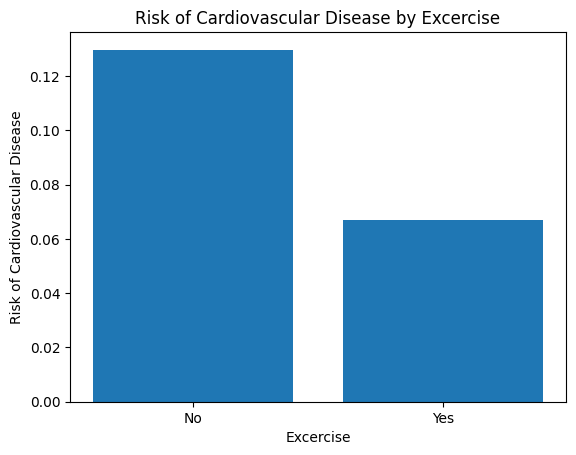

In [26]:
excercise_group = data_without_duplicates.groupby('Exercise')
risk_by_excercise = excercise_group['Cardio_Disease'].mean()
excercise_group_names = {
    0: "No",
    1: "Yes"
}
plt.bar(excercise_group_names.values(), risk_by_excercise.values)
plt.xlabel('Excercise')
plt.ylabel('Risk of Cardiovascular Disease')
plt.title('Risk of Cardiovascular Disease by Excercise')
plt.xticks(rotation=0)
plt.show()


## The chances of having Cardiovascular diseases according to their Skin Cancer

In [27]:
data_count['Skin_Cancer'] = data_count['Skin_Cancer'].replace({
    0: "No",
    1: "Yes"
})

skin_cancer_count = data_count['Skin_Cancer'].value_counts().sort_values()
print('Number of People According to their Skin_Cancer (Sorted)')
skin_cancer_count

Number of People According to their Skin_Cancer (Sorted)


Skin_Cancer
Yes     29982
No     278088
Name: count, dtype: int64

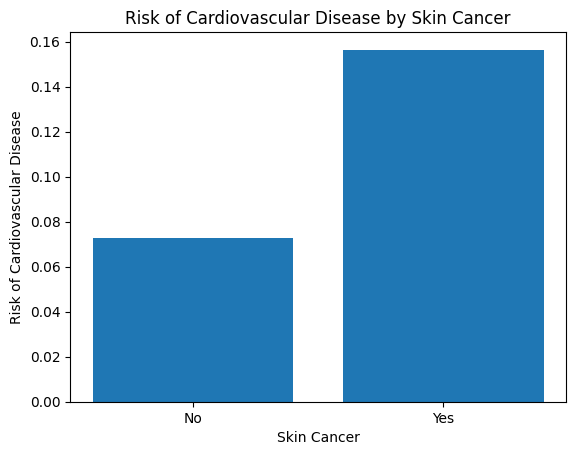

In [28]:
skin_cancer_group = data_without_duplicates.groupby('Skin_Cancer')
risk_by_skin_cancer = skin_cancer_group['Cardio_Disease'].mean()
skin_cancer_group_names = {
    0: "No",
    1: "Yes"
}
plt.bar(skin_cancer_group_names.values(), risk_by_skin_cancer.values)
plt.xlabel('Skin Cancer')
plt.ylabel('Risk of Cardiovascular Disease')
plt.title('Risk of Cardiovascular Disease by Skin Cancer')
plt.xticks(rotation=0)
plt.show()


## The chances of having Cardiovascular diseases if they have Depression

In [29]:
data_count['Depression'] = data_count['Depression'].replace({
    0: "No",
    1 : 'Yes'
})

depression_count = data_count['Depression'].value_counts().sort_values()
print('Number of People According to their Depression (Sorted)')
depression_count

Number of People According to their Depression (Sorted)


Depression
Yes     61884
No     246186
Name: count, dtype: int64

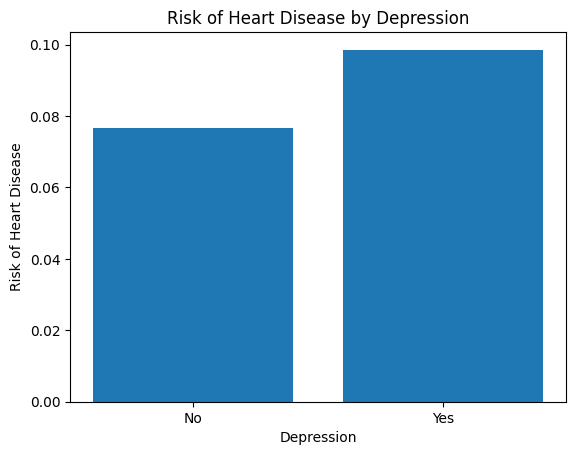

In [30]:
depression_group = data_without_duplicates.groupby('Depression')
risk_by_depression = depression_group['Cardio_Disease'].mean()

depression_group_names = {
    0: "No",
    1: "Yes"
}
plt.bar(depression_group_names.values(), risk_by_depression.values)
plt.xlabel('Depression')
plt.ylabel('Risk of Heart Disease')
plt.title('Risk of Heart Disease by Depression')
plt.xticks(rotation=0)
plt.show()

## The chances of having Cardiovascular diseases according to their Smoking History

In [31]:
data_count['Smoking_History'] = data_count['Smoking_History'].replace({
     0: "No",
    1: "Yes"
})

smoking_count = data_count['Smoking_History'].value_counts().sort_values()
print('Number of People According to their Smoking_History (Sorted)')
smoking_count

Number of People According to their Smoking_History (Sorted)


Smoking_History
Yes    125158
No     182912
Name: count, dtype: int64

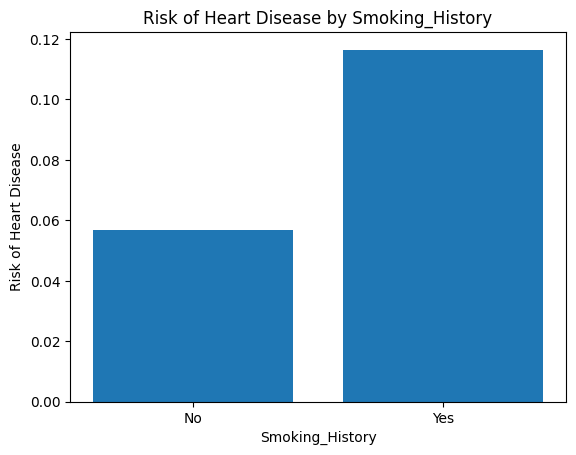

In [32]:
smoking_group = data_without_duplicates.groupby('Smoking_History')
risk_by_smoking = smoking_group['Cardio_Disease'].mean()

smoking_group_names = {
    0: "No",
    1: "Yes"
}
plt.bar(smoking_group_names.values(), risk_by_smoking.values)
plt.xlabel('Smoking_History')
plt.ylabel('Risk of Heart Disease')
plt.title('Risk of Heart Disease by Smoking_History')
plt.xticks(rotation=0)
plt.show()

## The chances of having Cardiovascular diseases according to their Diabetes

In [33]:
data_count['Diabetes'] = data_count['Diabetes'].replace({
     0: "No",
     1: "No, pre-diabetes or borderline diabetes",
     2: "Yes",
     3: "Yes, but female told only during pregnancy"
})

diabetes_count = data_count['Diabetes'].value_counts().sort_values()
print('Number of People According to their Diabetes (Sorted)')
diabetes_count

Number of People According to their Diabetes (Sorted)


Diabetes
Yes, but female told only during pregnancy      2646
No, pre-diabetes or borderline diabetes         6896
Yes                                            40160
No                                            258368
Name: count, dtype: int64

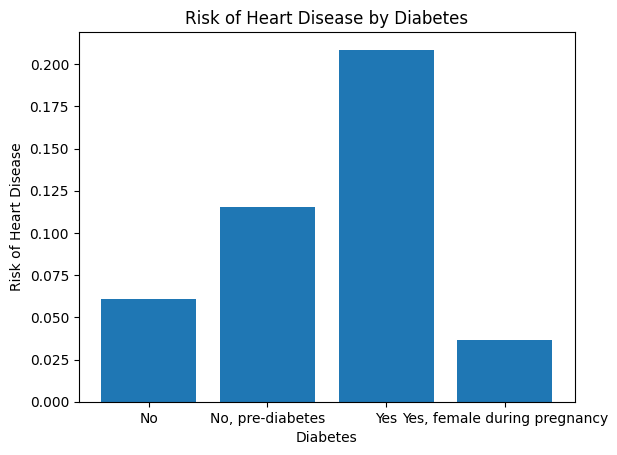

In [34]:
diabetes_group = data_without_duplicates.groupby('Diabetes')
risk_by_diabetes = diabetes_group['Cardio_Disease'].mean()

diabetes_group_names = {
    0: "No",
     1: "No, pre-diabetes", # No, pre-diabetes or borderline diabetes AS No, pre-diabetes
     2: "Yes",
     3: "Yes, female during pregnancy" # Yes, but female told only during pregnancy AS Yes, female during pregnancy
}
plt.bar(diabetes_group_names.values(), risk_by_diabetes.values)
plt.xlabel('Diabetes')
plt.ylabel('Risk of Heart Disease')
plt.title('Risk of Heart Disease by Diabetes')
plt.xticks(rotation=0)
plt.show()

In [35]:
data_without_duplicates.columns

Index(['General_Health', 'Exercise', 'Skin_Cancer', 'Other_Cancer',
       'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category',
       'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'Cardio_Disease'],
      dtype='object')

In [36]:
X = data_without_duplicates.drop('Cardio_Disease', axis=1) # use all features except target column
y = data_without_duplicates['Cardio_Disease'] # target data

In [37]:
print(data.dtypes)

General_Health                   object
Exercise                         object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64
Fruit_Consumption                 int64
Green_Vegetables_Consumption      int64
Cardio_Disease                   object
dtype: object


In [38]:
print(data_count)
data['Cardio_Disease'].value_counts()

       General_Health Exercise Skin_Cancer Other_Cancer Depression  \
0                Poor       No          No           No         No   
1           Very Good       No          No           No         No   
2           Very Good      Yes          No           No         No   
3                Poor      Yes          No           No         No   
4                Good       No          No           No         No   
...               ...      ...         ...          ...        ...   
308849      Very Good      Yes          No           No         No   
308850           Fair      Yes          No           No         No   
308851      Very Good      Yes          No           No        Yes   
308852      Very Good      Yes          No           No         No   
308853      Excellent      Yes          No           No         No   

                                          Diabetes Arthritis     Sex  \
0                                               No       Yes  Female   
1              

Cardio_Disease
No     283883
Yes     24971
Name: count, dtype: int64

## Correlation

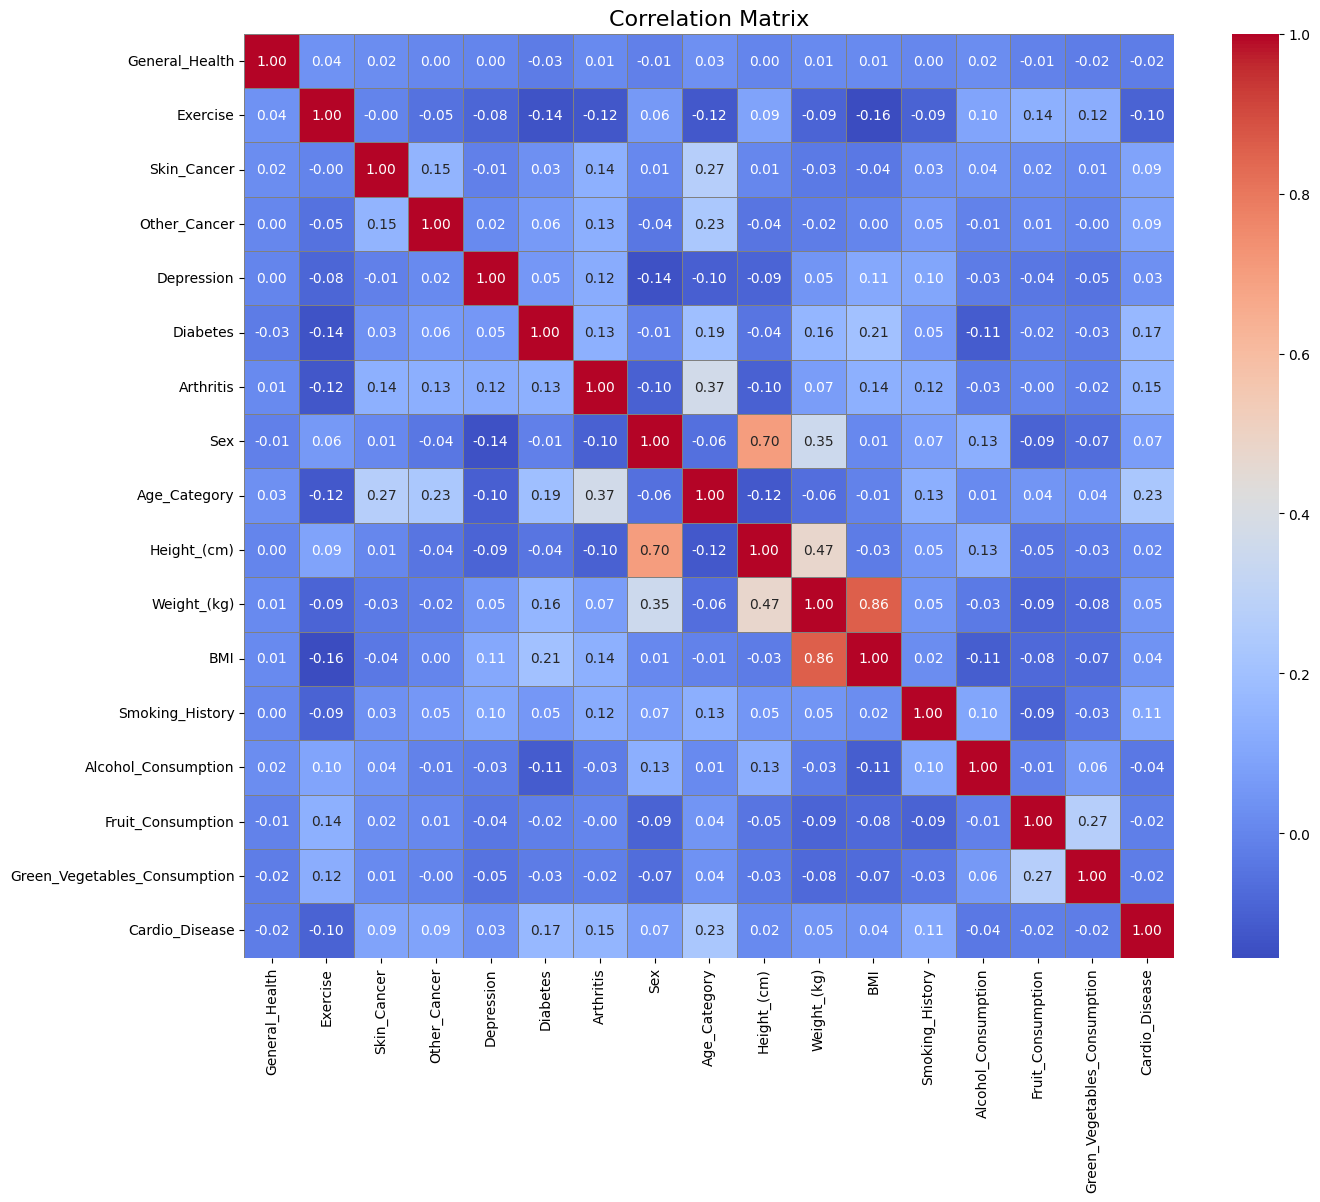

In [39]:
corr_matrix = data_without_duplicates.corr()

# Plotting the heatmap with annotations
plt.figure(figsize=(15, 12))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='gray')

# Adding title to the heatmap
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## OverSampling

In [40]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.8, random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled).value_counts())

Cardio_Disease
0    283103
1    226482
Name: count, dtype: int64


In [41]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

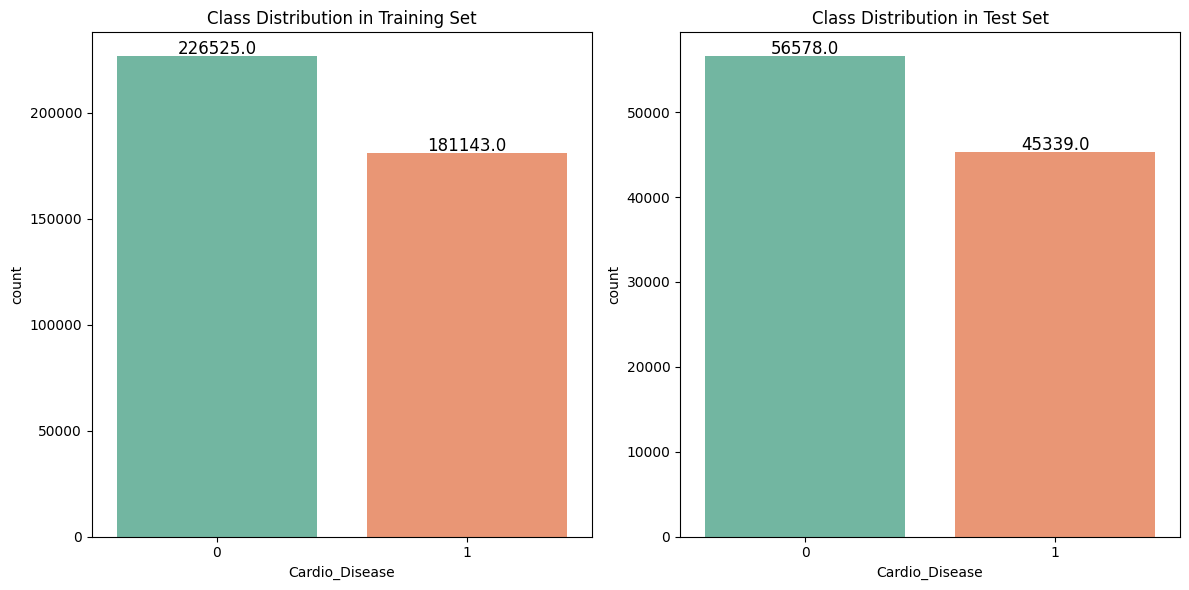

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train and y_test are defined and contain categorical data (target variable)

plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x=y_train, palette='Set2')
plt.title('Class Distribution in Training Set')

# Add value labels on top of the bars in the training set
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 fontsize=12, color='black', 
                 xytext=(0, 5), textcoords='offset points')

# Plot for test data
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x=y_test, palette='Set2')
plt.title('Class Distribution in Test Set')

# Add value labels on top of the bars in the test set
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', 
                 fontsize=12, color='black', 
                 xytext=(0, 5), textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()


## Boruta 

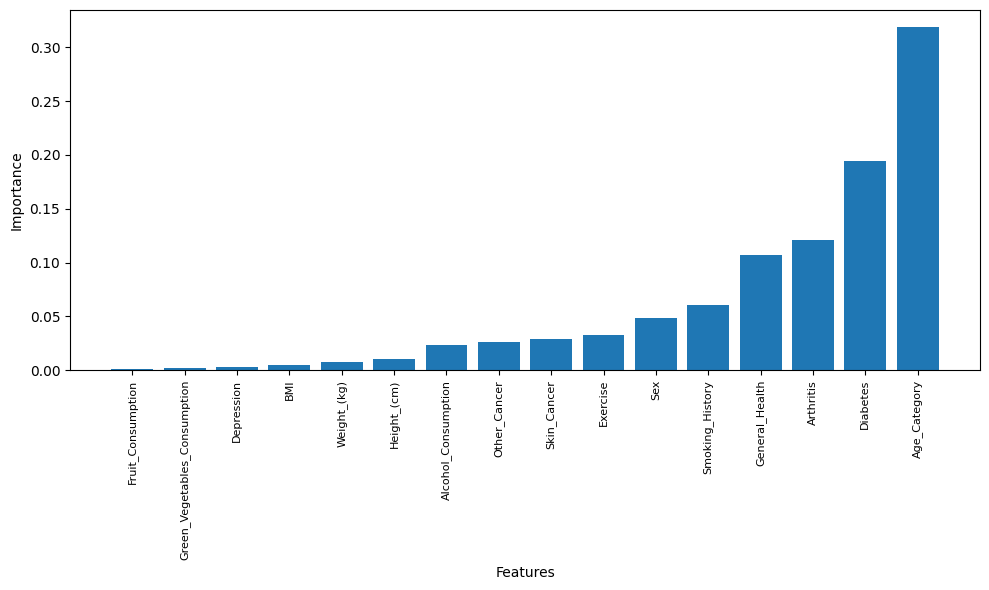

In [44]:
rf = RandomForestClassifier(n_estimators=200,n_jobs=-1, max_depth=5)
boruta = BorutaPy(rf, random_state=42)
boruta.fit(X.values, y.values)

# Access Boruta ImpHistory (feature importance history)
imp_history = boruta.importance_history_

# Apply the same logic as in your R code
lz = {}
for i in range(imp_history.shape[1]):
    lz[X.columns[i]] = imp_history[~np.isnan(imp_history[:, i]), i]
    
# Sort and get the median for each feature
labels = {k: np.median(v) for k, v in lz.items()}
sorted_labels = dict(sorted(labels.items(), key=lambda item: item[1]))


##Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_labels)), [labels[key] for key in sorted_labels.keys()])
plt.xticks(ticks=np.arange(len(sorted_labels)), labels=sorted_labels.keys(), rotation=90, fontsize=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


## Random Forest Model Evaluation

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
param_dist = {
    'n_estimators': [400,500,600],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

In [62]:
rf = RandomForestClassifier(random_state=42, verbose=2)

In [63]:
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)

start_time = time.time()
random_search_rf.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time

print(f"Random Forest model training time: {runtime:.2f} seconds")

Random Forest model training time: 1650.69 seconds


In [64]:
y_pred_rf = random_search_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}%".format(accuracy_rf * 100))
print(classification_report(y_test, y_pred_rf))
print("Best Estimator: ",random_search_rf.best_estimator_)
print("Best Params: ",random_search_rf.best_params_)

Accuracy: 89.50%
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     56578
           1       0.88      0.88      0.88     45339

    accuracy                           0.89    101917
   macro avg       0.89      0.89      0.89    101917
weighted avg       0.90      0.89      0.89    101917

Best Estimator:  RandomForestClassifier(bootstrap=False, min_samples_leaf=3, min_samples_split=6,
                       n_estimators=600, random_state=42, verbose=2)
Best Params:  {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 600}


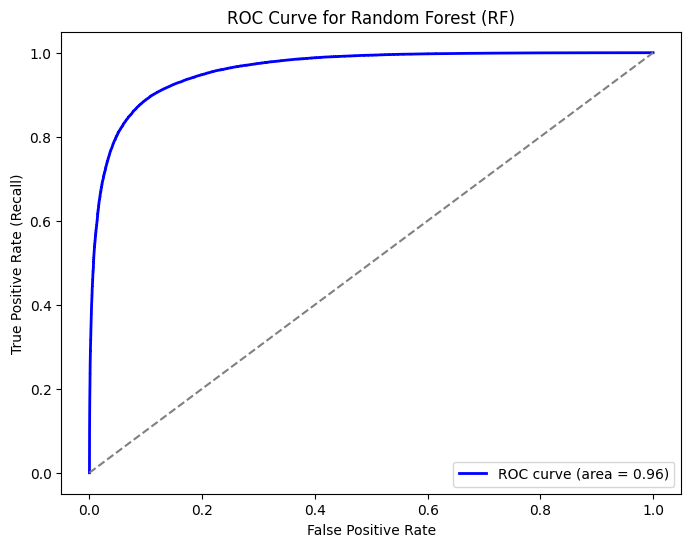

Area Under the ROC Curve (AUC): 0.96


In [65]:

y_pred_prob_rf = random_search_rf.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Random Forest (RF)')
plt.legend(loc='lower right')
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")

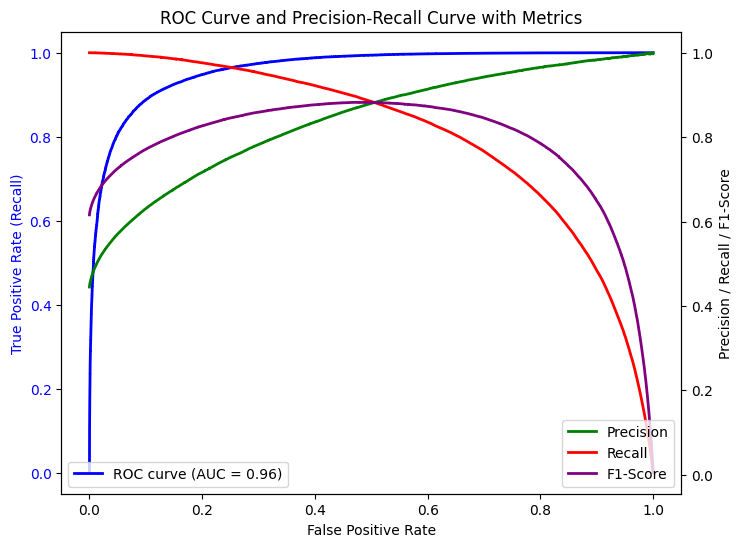

In [66]:

# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_rf = random_search_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_rf)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


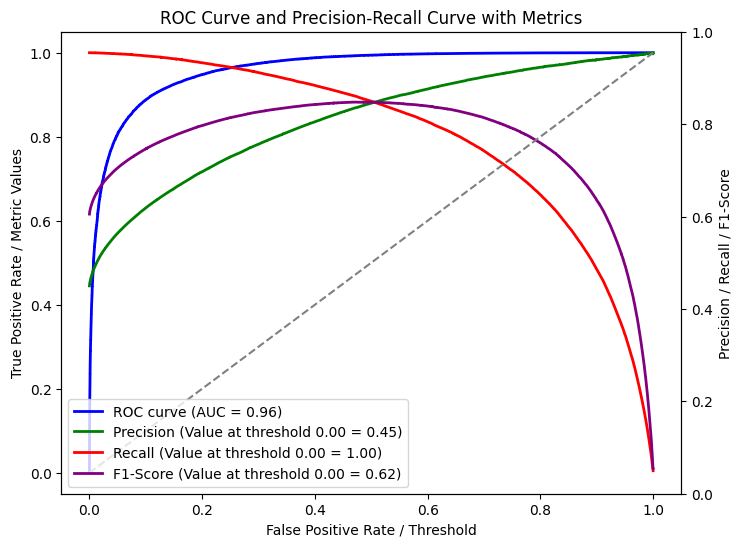

In [67]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_rf = random_search_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_rf)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Support Vector Machine (SVM) Model Evaluation

In [35]:
from sklearn.svm import SVC

In [ ]:
param_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [ ]:
svm_clf = SVC(random_state=42, verbose=2,probability=True)

In [ ]:
random_search_svm = RandomizedSearchCV(estimator=svm_clf,
                                      param_distributions=param_svm,
                                      n_iter=50, cv=5, scoring='accuracy',
                                      random_state=42, verbose=2)

In [ ]:

start_time = time.time()
random_search_svm.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time
print(f"Support Vector Machine(SVM) model training time: {runtime:.2f} seconds")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  21.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  23.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  24.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  19.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  19.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  14.9s
[CV] END .....................C=0.1, gamma=1, k

In [ ]:
y_pred_svm = random_search_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy: {:.2f}%".format(accuracy_svm * 100))
print(classification_report(y_test, y_pred_svm))
print("Best Estimator: ",random_search_svm.best_estimator_)
print("Best Params: ",random_search_svm.best_params_)

Accuracy: 59.30%
              precision    recall  f1-score   support

           0       0.58      0.98      0.73     56578
           1       0.82      0.11      0.19     45339

    accuracy                           0.59    101917
   macro avg       0.70      0.54      0.46    101917
weighted avg       0.69      0.59      0.49    101917

Best Estimator:  SVC(C=10, gamma=0.1, probability=True, random_state=42, verbose=2)
Best Params:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}


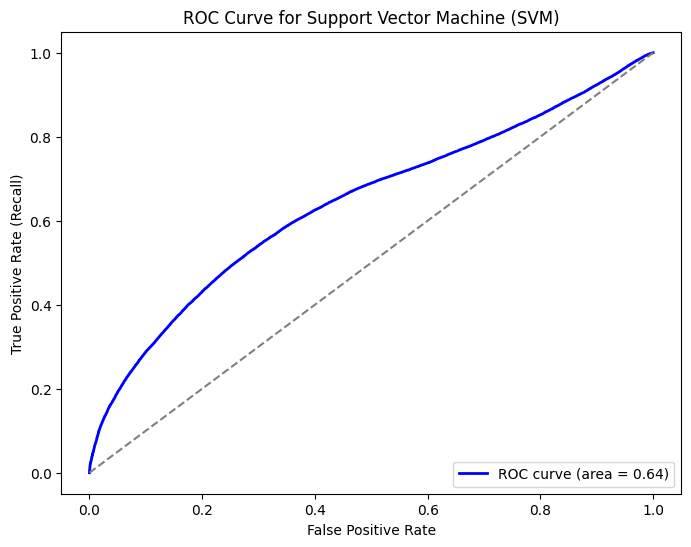

Area Under the ROC Curve (AUC): 0.64


In [ ]:
# Predict probabilities for the positive class (needed for ROC curve)
y_pred_prob_svm = random_search_svm.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svm)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Support Vector Machine (SVM)')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC value
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


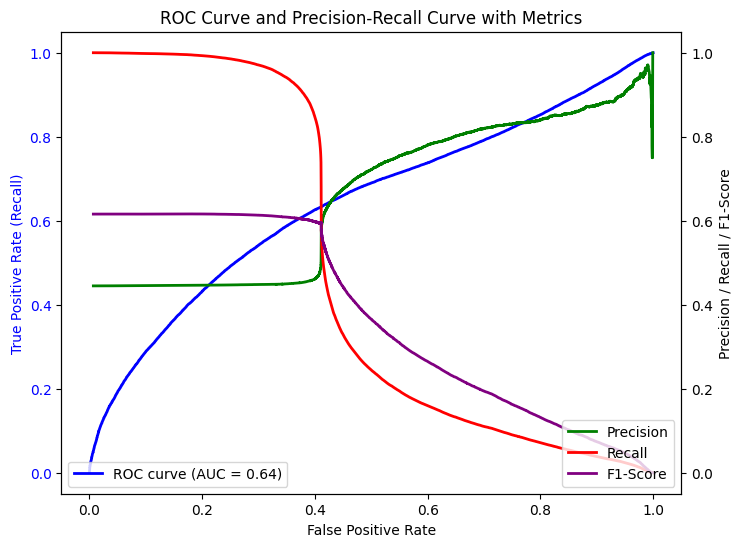

In [ ]:

y_pred_prob_svm = random_search_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_svm)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_svm)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


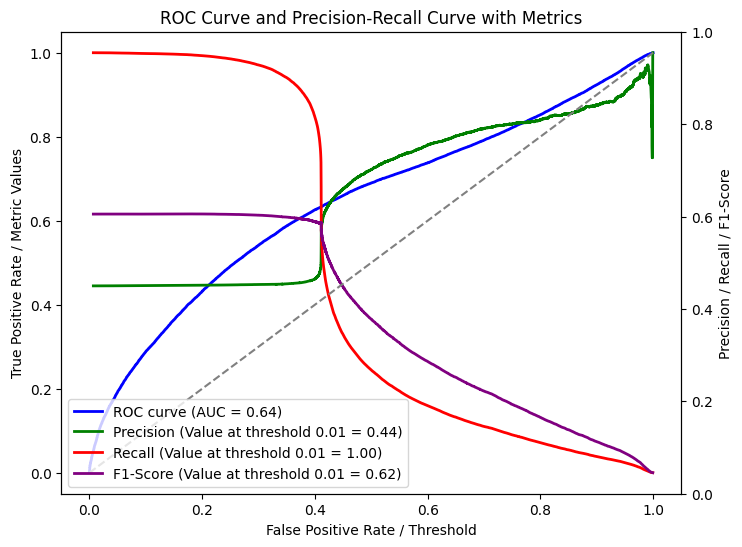

In [ ]:

y_pred_prob_svm = random_search_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_svm)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_svm)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Gaussian Naive Bayes (GNB) Model Evaluation

In [36]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()

In [ ]:
param_gnb = {'priors': [None, [0.3, 0.7], [0.6, 0.4]],
             'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

In [ ]:
random_search_gnb = RandomizedSearchCV(gnb, param_distributions=param_gnb, n_iter=50, cv=5, scoring='accuracy', random_state=42)

start_time = time.time()

random_search_gnb.fit(X_train, y_train)

end_time = time.time()

runtime = end_time - start_time

print(f"Gaussian Naive Bayes(GNB) model training time: {runtime:.2f} seconds")

Gaussian Naive Bayes(GNB) model training time: 10.31 seconds


In [ ]:
y_pred_gnb = random_search_gnb.predict(X_test)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("Accuracy: {:.2f}%".format(accuracy_gnb * 100))
print(classification_report(y_test, y_pred_gnb))
print("Best Estimator: ",random_search_gnb.best_estimator_)
print("Best Params: ",random_search_gnb.best_params_)

Accuracy: 75.21%
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     56578
           1       0.71      0.75      0.73     45339

    accuracy                           0.75    101917
   macro avg       0.75      0.75      0.75    101917
weighted avg       0.75      0.75      0.75    101917

Best Estimator:  GaussianNB(var_smoothing=1e-05)
Best Params:  {'var_smoothing': 1e-05, 'priors': None}


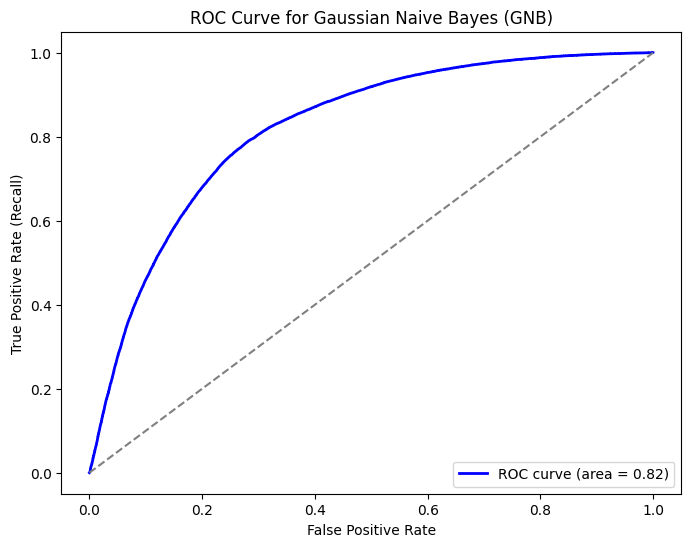

Area Under the ROC Curve (AUC): 0.82


In [ ]:

y_pred_prob_gnb = random_search_gnb.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Gaussian Naive Bayes (GNB)')
plt.legend(loc='lower right')
plt.show()


print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


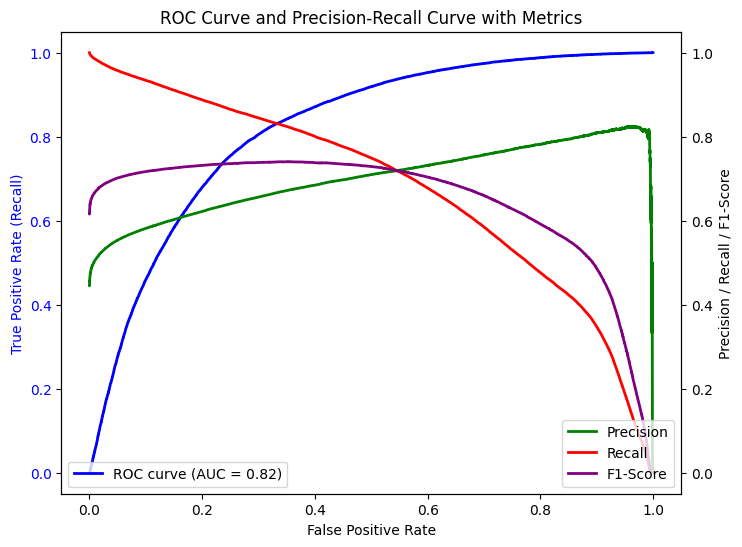

In [ ]:

y_pred_prob_gnb = random_search_gnb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_gnb)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


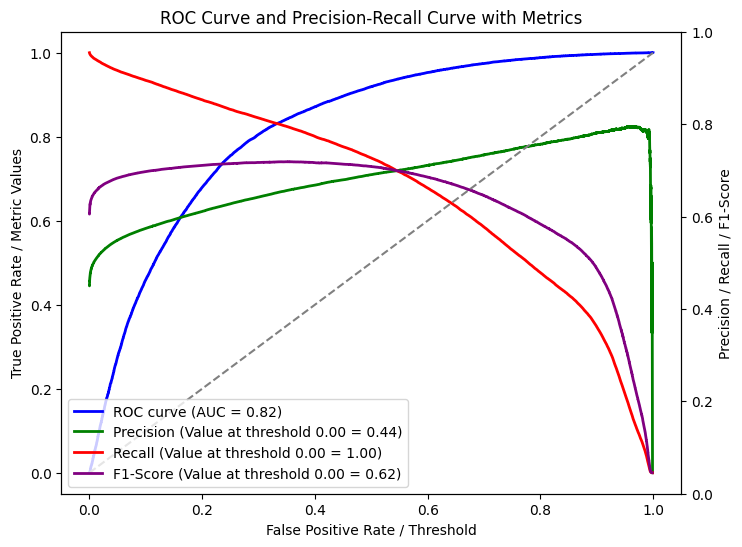

In [ ]:

y_pred_prob_gnb = random_search_gnb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_gnb)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Logistic Regression Model Evaluation

In [37]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=42, verbose=2)

In [ ]:
param_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': ['balanced', None],
    'warm_start': [True, False],
}

In [ ]:
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_lr, n_iter=50, cv=5, scoring='accuracy', random_state=42)
start_time = time.time()

random_search_lr.fit(X_train, y_train)
end_time = time.time()


runtime = end_time - start_time
print(f"\nLogistic Regression(LR) model training time: {runtime:.2f} seconds")

convergence after 46 epochs took 7 seconds
convergence after 46 epochs took 7 seconds
convergence after 46 epochs took 7 seconds
convergence after 46 epochs took 7 seconds
convergence after 46 epochs took 7 seconds
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 14 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 13 seconds
max_iter reached after 15 seconds
max_iter reached after 15 seconds
max_iter reached after 14 seconds
max_iter reached after 15 seconds
max_iter reached after 15 seconds
convergence after 22 epochs took 3 seconds
convergence after 23 epochs took 4 seconds
convergence after 22 epochs took 3 seconds
convergence after 27 epochs took 4 seconds
convergence after 24 epochs took 3 seconds
conve

In [ ]:
y_pred_lr = random_search_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy: {:.2f}%".format(accuracy_lr * 100))
print(classification_report(y_test, y_pred_lr))
print("Best Estimator: ",random_search_lr.best_estimator_)
print("Best Params: ",random_search_lr.best_params_)

Accuracy: 74.24%
              precision    recall  f1-score   support

           0       0.79      0.72      0.76     56578
           1       0.69      0.77      0.73     45339

    accuracy                           0.74    101917
   macro avg       0.74      0.74      0.74    101917
weighted avg       0.75      0.74      0.74    101917

Best Estimator:  LogisticRegression(C=1, class_weight='balanced', max_iter=300,
                   multi_class='multinomial', penalty=None, random_state=42,
                   verbose=2)
Best Params:  {'warm_start': False, 'solver': 'lbfgs', 'penalty': None, 'multi_class': 'multinomial', 'max_iter': 300, 'class_weight': 'balanced', 'C': 1}


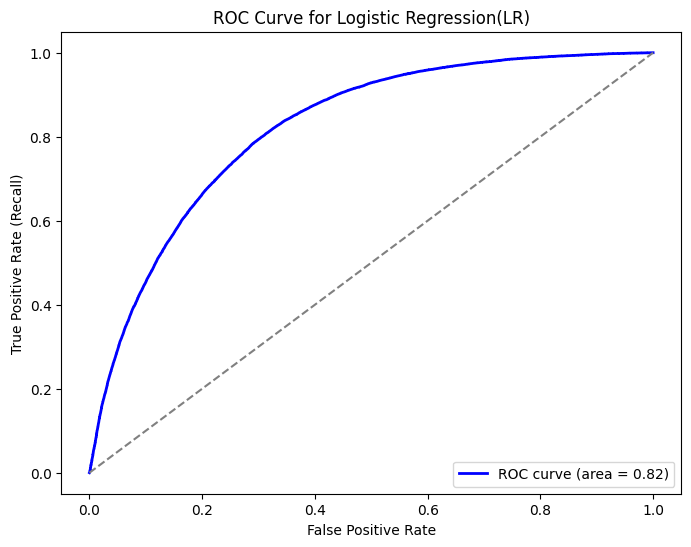

Area Under the ROC Curve (AUC): 0.82


In [ ]:

y_pred_prob_lr = random_search_lr.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Logistic Regression(LR)')
plt.legend(loc='lower right')
plt.show()


print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


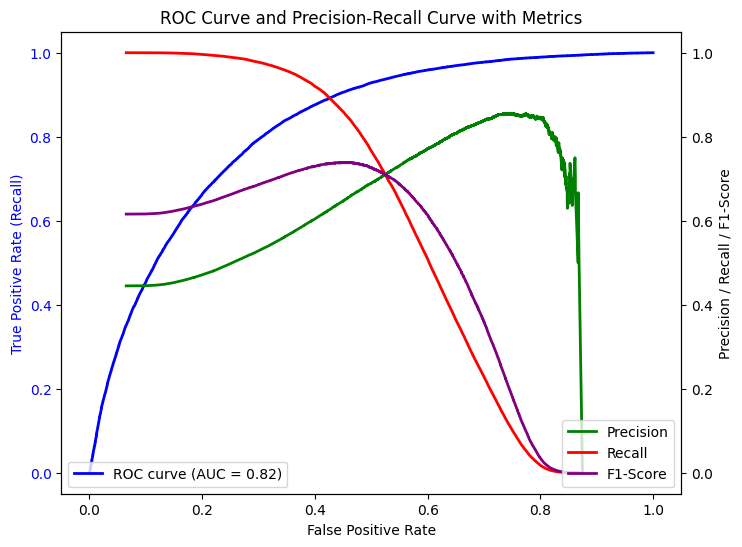

In [ ]:
y_pred_prob_lr = random_search_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_lr)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()

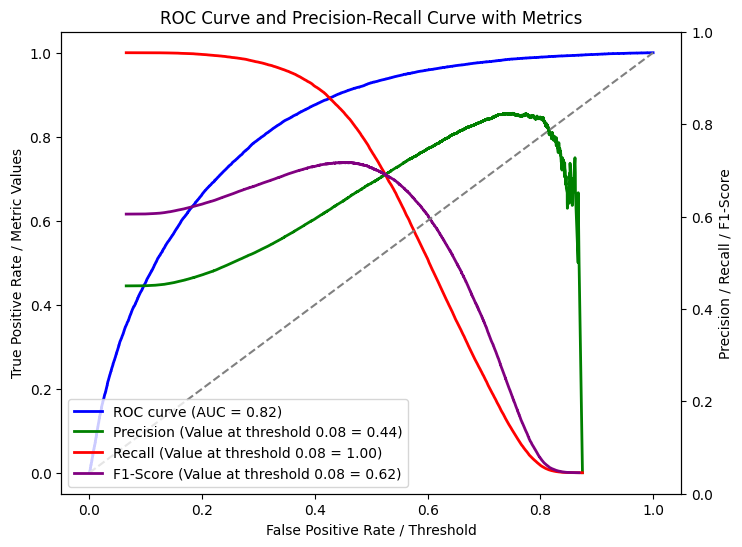

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_lr = random_search_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_lr)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Decision Tree Model Evaluation

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
param_dtree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2', None, 0.5],
    'min_samples_split': [2, 5, 10, 6, 8],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'class_weight': ['balanced', 'balanced_subsample', None],
}


In [ ]:
random_search_dtree = RandomizedSearchCV(dtree, param_distributions=param_dtree, n_iter=50, cv=5, scoring='accuracy', random_state=42)

start_time = time.time()

random_search_dtree.fit(X_train, y_train)
end_time = time.time()

runtime = end_time - start_time

print(f"Decision Tree model training time: {runtime:.2f} seconds")

Decision Tree model training time: 98.28 seconds


In [ ]:
y_pred_dtree = random_search_dtree.predict(X_test)
accuracy_dtree= accuracy_score(y_test, y_pred_dtree)
print("Accuracy: {:.2f}%".format(accuracy_dtree * 100))
print(classification_report(y_test, y_pred_dtree))
print("Best Estimator: ",random_search_dtree.best_estimator_)
print("Best Params: ",random_search_dtree.best_params_)

Accuracy: 83.59%
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     56578
           1       0.79      0.86      0.82     45339

    accuracy                           0.84    101917
   macro avg       0.83      0.84      0.83    101917
weighted avg       0.84      0.84      0.84    101917

Best Estimator:  DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features='sqrt', min_samples_split=6)
Best Params:  {'splitter': 'best', 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced'}


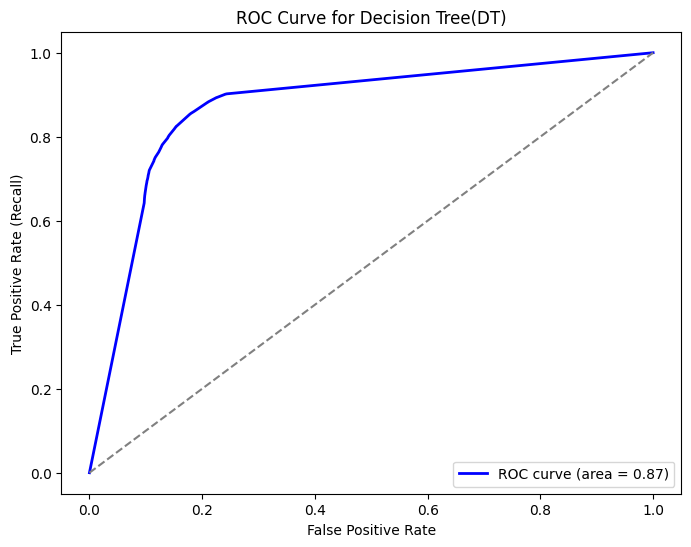

Area Under the ROC Curve (AUC): 0.87


In [ ]:


y_pred_prob_DT = random_search_dtree.predict_proba(X_test)[:, 1]  


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_DT)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Decision Tree(DT)')
plt.legend(loc='lower right')
plt.show()


print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


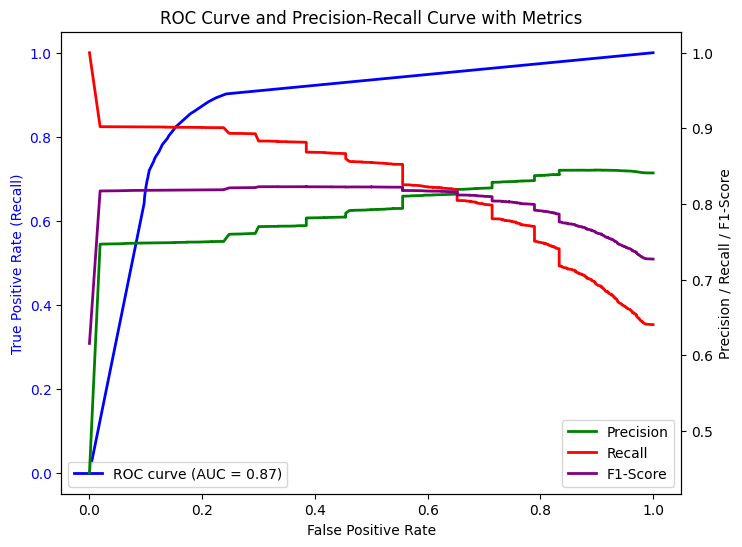

In [ ]:
y_pred_prob_DT = random_search_dtree.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_DT)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_DT)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()

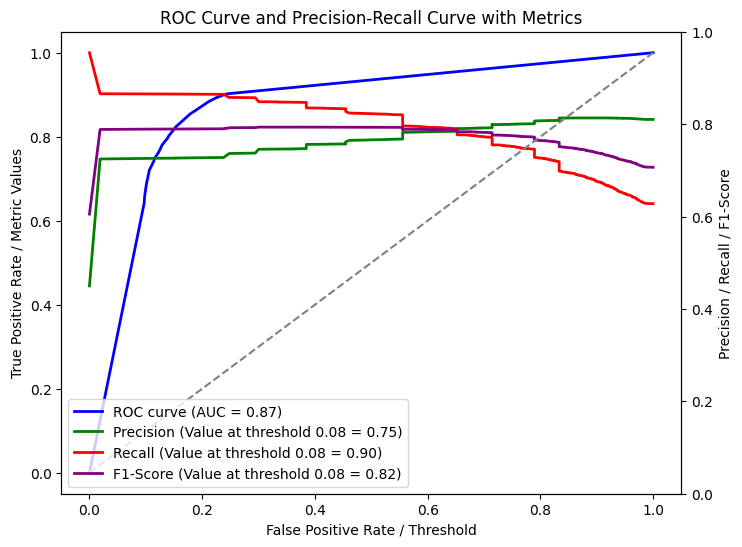

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_DT = random_search_dtree.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_DT)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_DT)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Adaboosting Model Evaluation


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost = AdaBoostClassifier()

In [ ]:
param_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state' : [42]
}

In [ ]:
random_search_adaboost = RandomizedSearchCV(adaboost, param_distributions=param_adaboost, n_iter=50, cv=5, scoring='accuracy', random_state=42)

start_time = time.time()
random_search_adaboost.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time

print(f"AdaBoosting model training time: {runtime:.2f} seconds")


AdaBoosting model training time: 1022.00 seconds


In [ ]:
y_pred_adaboost = random_search_adaboost.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("Accuracy: {:.2f}%".format(accuracy_adaboost * 100))
print(classification_report(y_test, y_pred_adaboost))
print("Best Estimator: ",random_search_adaboost.best_estimator_)
print("Best Params: ",random_search_adaboost.best_params_)

Accuracy: 80.49%
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     56578
           1       0.78      0.79      0.78     45339

    accuracy                           0.80    101917
   macro avg       0.80      0.80      0.80    101917
weighted avg       0.81      0.80      0.81    101917

Best Estimator:  AdaBoostClassifier(algorithm='SAMME', n_estimators=200, random_state=42)
Best Params:  {'random_state': 42, 'n_estimators': 200, 'learning_rate': 1.0, 'algorithm': 'SAMME'}


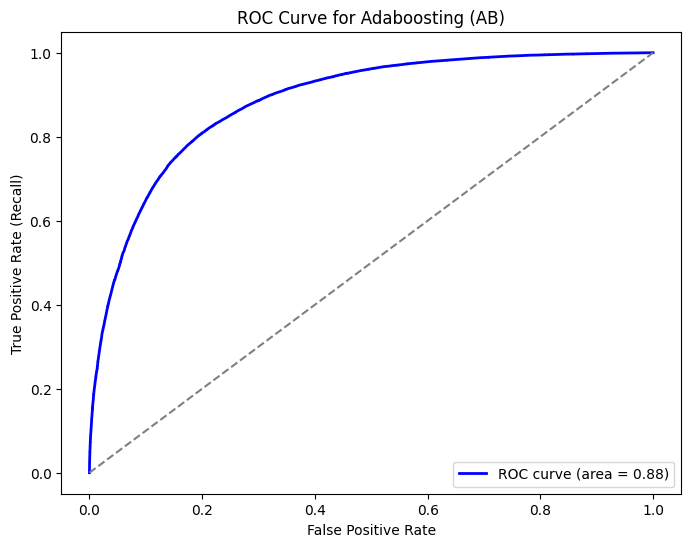

Area Under the ROC Curve (AUC): 0.88


In [ ]:

y_pred_prob_ab = random_search_adaboost.predict_proba(X_test)[:, 1]  


fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ab)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Adaboosting (AB)')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC value
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


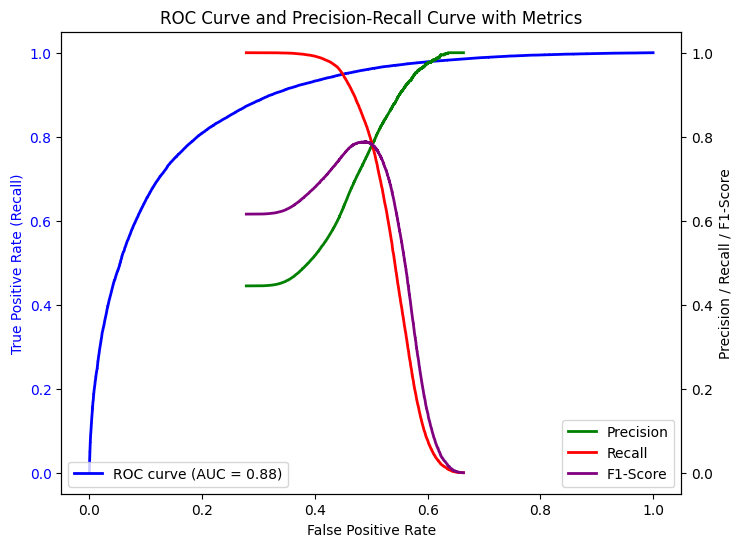

In [ ]:

y_pred_prob_ab = random_search_adaboost.predict_proba(X_test)[:, 1]


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_ab)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_ab)


f1_scores = 2 * (precision * recall) / (precision + recall)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


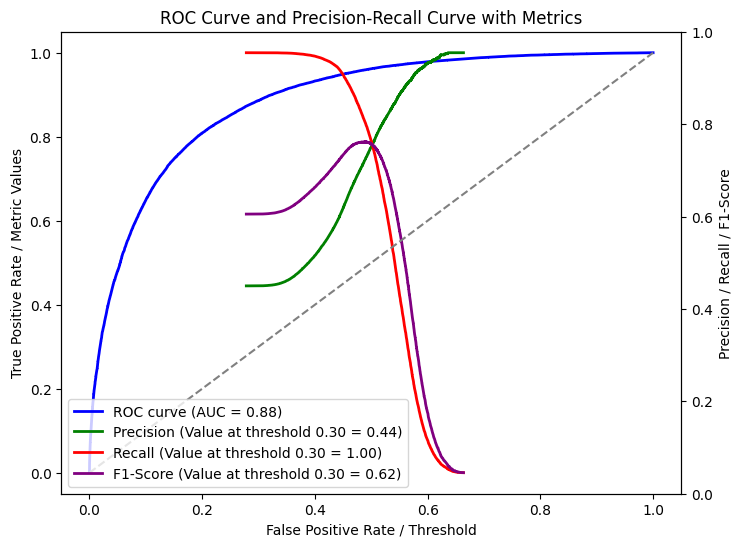

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_ad = random_search_adaboost.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_ad)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_ad)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## KNN Model Evaluation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
param_knn = {'n_neighbors': [3, 5, 7, 9],
             'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski','Hamming']
             
             }

In [ ]:
random_search_knn = RandomizedSearchCV(knn, param_distributions=param_knn,n_iter=50, cv=5, scoring='accuracy', random_state=42)

In [ ]:
start_time = time.time()
random_search_knn.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time

print(f"K-Nearest Neighbor model training time: {runtime:.2f} seconds")

K-Nearest Neighbor model training time: 1588.47 seconds


In [ ]:
y_pred_knn = random_search_knn.predict(X_test)
accuracy_KNN = accuracy_score(y_test, y_pred_knn)
print("Accuracy: {:.2f}%".format(accuracy_KNN * 100))
print(classification_report(y_test, y_pred_knn))
print("Best Estimator: ",random_search_knn.best_estimator_)
print("Best Params: ",random_search_knn.best_params_)

Accuracy: 89.38%
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     56578
           1       0.81      0.99      0.89     45339

    accuracy                           0.89    101917
   macro avg       0.90      0.90      0.89    101917
weighted avg       0.91      0.89      0.89    101917

Best Estimator:  KNeighborsClassifier(metric='manhattan', n_neighbors=3)
Best Params:  {'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}


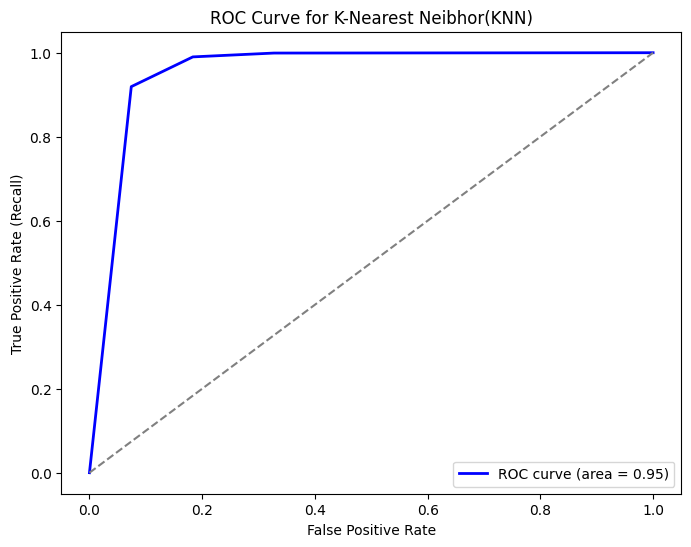

Area Under the ROC Curve (AUC): 0.95


In [ ]:

y_pred_prob_knn = random_search_knn.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for K-Nearest Neibhor(KNN)')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC value
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


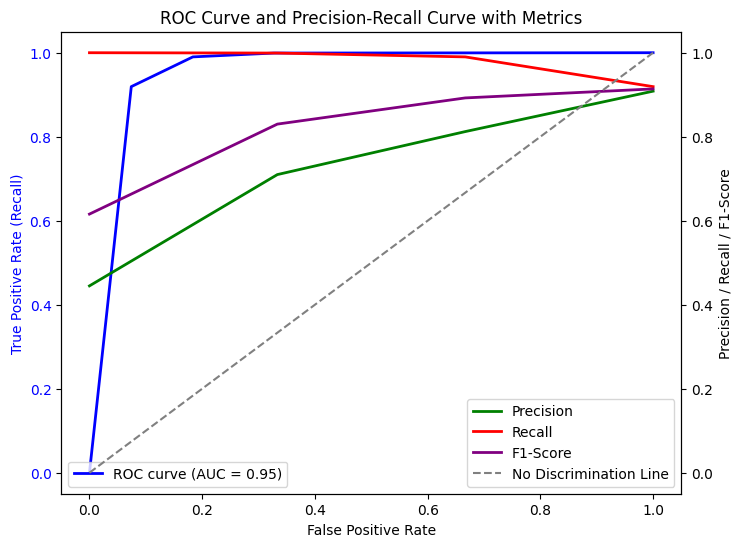

In [ ]:

y_pred_prob_knn = random_search_knn.predict_proba(X_test)[:, 1]


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_knn)


f1_scores = 2 * (precision * recall) / (precision + recall)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


4


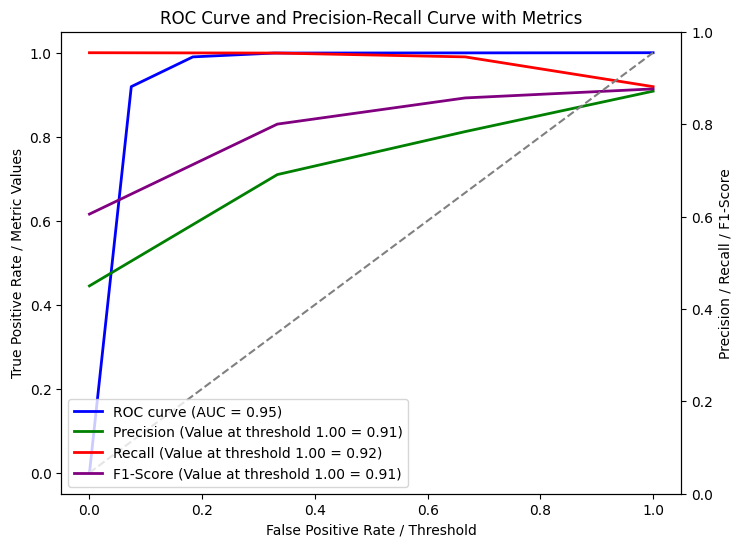

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_knn = random_search_knn.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_knn)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Check the size of the thresholds array
print(len(pr_thresholds))

# Ensure that the threshold_index is within the valid range
threshold_index = min(10, len(pr_thresholds) - 1)  # Make sure the index is within bounds

# Now, safely access the threshold value
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## XGB Model Evaluation

In [ ]:
from xgboost import XGBClassifier

In [ ]:
XGB = XGBClassifier()

In [ ]:
param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [ ]:
random_search_xgb = RandomizedSearchCV(XGB, param_distributions=param_xgb, n_iter=50, cv=5, random_state=42)

In [ ]:
start_time = time.time()
random_search_xgb.fit(X_train, y_train)
end_time = time.time()

runtime = end_time - start_time

print(f"Extreme Gradient Boosting model training time: {runtime:.2f} seconds")

Extreme Gradient Boosting model training time: 347.63 seconds


In [ ]:
y_pred_xgb = random_search_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: {:.2f}%".format(accuracy_xgb * 100))
print(classification_report(y_test, y_pred_xgb))

print("Best Estimator: ",random_search_xgb.best_estimator_)
print("Best Params: ",random_search_xgb.best_params_)

Accuracy: 88.00%
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     56578
           1       0.87      0.85      0.86     45339

    accuracy                           0.88    101917
   macro avg       0.88      0.88      0.88    101917
weighted avg       0.88      0.88      0.88    101917

Best Estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              mult

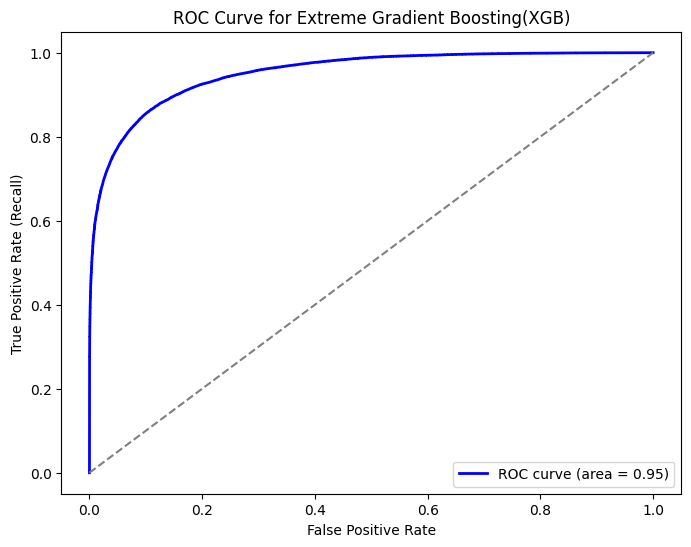

Area Under the ROC Curve (AUC): 0.95


In [ ]:

y_pred_prob_xgb = random_search_xgb.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Extreme Gradient Boosting(XGB)')
plt.legend(loc='lower right')
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


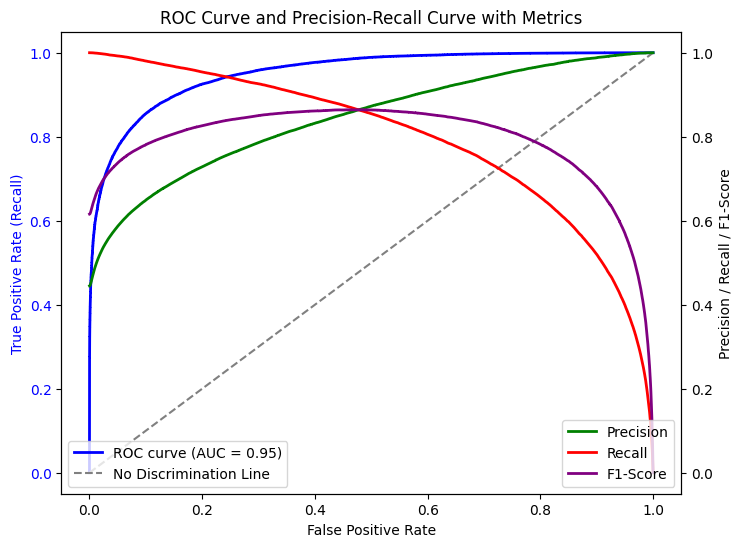

In [ ]:

y_pred_prob_xgb = random_search_xgb.predict_proba(X_test)[:, 1]


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_xgb)


f1_scores = 2 * (precision * recall) / (precision + recall)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()

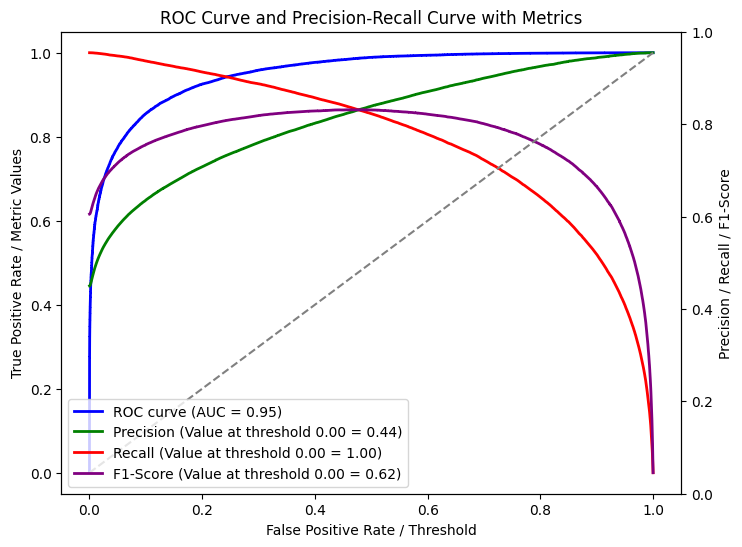

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_xgb = random_search_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_xgb)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Gradient Boosting Model Evaluation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Define the parameter grid for Gradient Boosting
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting trees
    'max_features': ['auto', 'sqrt', None]
}


In [ ]:
gb = GradientBoostingClassifier(random_state=42)

In [ ]:
random_search_gb = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=42)


In [ ]:
# Start the timer
start_time = time.time()

# Fit the model with RandomizedSearchCV
random_search_gb.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time

# Print the runtime
print(f"Gradient Boosting model training time: {runtime:.2f} seconds")

Gradient Boosting model training time: 23485.31 seconds


In [ ]:

y_pred_gb = random_search_gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy: {:.2f}%".format(accuracy_gb * 100))
print(classification_report(y_test, y_pred_gb))
print("Best Estimator: ", random_search_gb.best_estimator_)
print("Best Params: ", random_search_gb.best_params_)

Accuracy: 93.23%
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     56578
           1       0.94      0.90      0.92     45339

    accuracy                           0.93    101917
   macro avg       0.93      0.93      0.93    101917
weighted avg       0.93      0.93      0.93    101917

Best Estimator:  GradientBoostingClassifier(learning_rate=0.2, max_depth=9, min_samples_leaf=17,
                           min_samples_split=7, n_estimators=500,
                           random_state=42, subsample=0.9)
Best Params:  {'learning_rate': 0.2, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 17, 'min_samples_split': 7, 'n_estimators': 500, 'subsample': 0.9}


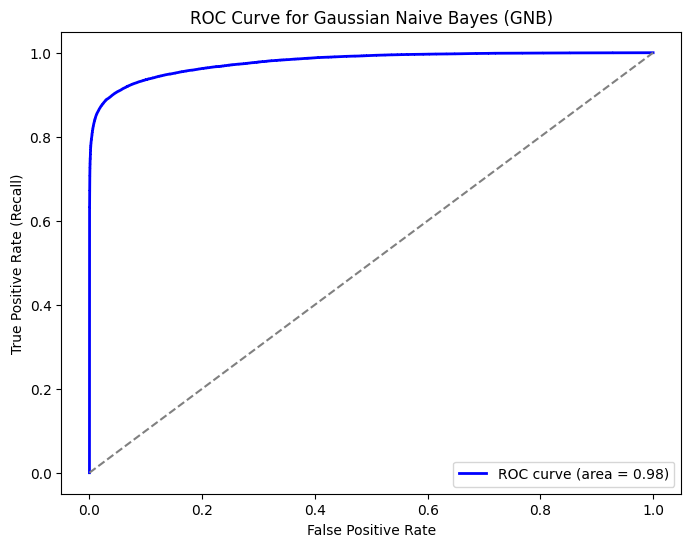

Area Under the ROC Curve (AUC): 0.98


In [ ]:

y_pred_prob_gnb = random_search_gb.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Gaussian Naive Bayes (GNB)')
plt.legend(loc='lower right')
plt.show()

# Optionally, print the AUC value
print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")


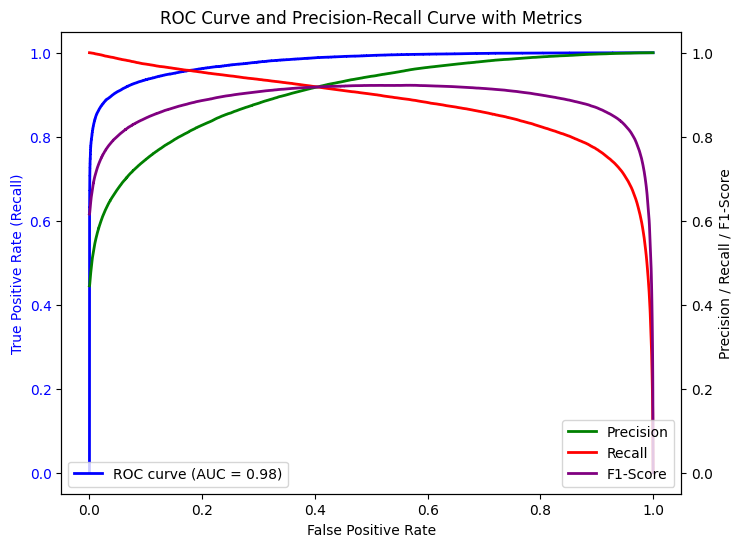

In [ ]:
y_pred_prob_gnb = random_search_gb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_gnb)

# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()


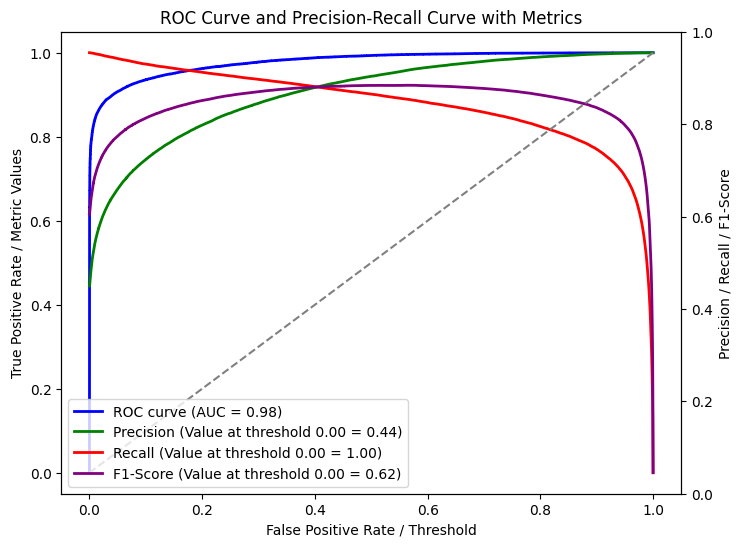

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_gnd = random_search_gb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_gnb)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_gnb)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Stacking 

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:

best_rf = random_search_rf.best_estimator_
best_svm = random_search_svm.best_estimator_
best_adaboost = random_search_adaboost.best_estimator_
best_knn = random_search_knn.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lr = random_search_lr.best_estimator_  # final estimator

In [ ]:
base_learners = [
     ('rf', best_rf),
     ('svm', best_svm),
    ('adaboost', best_adaboost),
    ('knn', best_knn),
     ('xgb', best_xgb)
]

In [ ]:
meta_learner = random_search_lr
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

In [ ]:

start_time = time.time()
stacking_model.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time
print(f"Stacking model training time: {runtime:.2f} seconds")

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

In [ ]:
# Make predictions
y_pred_stack = stacking_model.predict(X_test)

# Calculate accuracy and print the classification report
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print("Accuracy: {:.2f}%".format(accuracy_stack * 100))
print(classification_report(y_test, y_pred_stack))

Accuracy: 94.49%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     56578
           1       0.93      0.95      0.94     45339

    accuracy                           0.94    101917
   macro avg       0.94      0.95      0.94    101917
weighted avg       0.95      0.94      0.94    101917



In [ ]:
performance = {}
performance['RF'] = accuracy_rf
performance['SVM'] = accuracy_svm
performance['Adaboosting'] = accuracy_adaboost
performance['kNN'] = accuracy_KNN
performance['Logistic Regression'] = accuracy_lr
performance['XGB'] =accuracy_xgb
performance['DT'] = 0.8339
performance['GNB'] = 0.7521
performance["GB"] = 0.9323
performance['stacking_ensemble'] = 0.9449

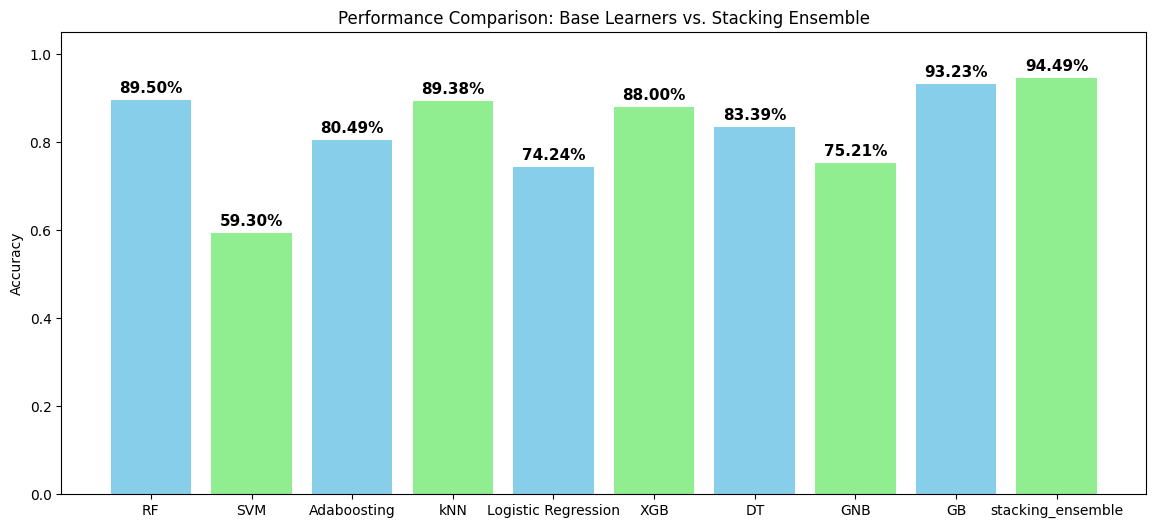

In [ ]:
performance_filtered = {k: performance[k] for k in ['RF','SVM','Adaboosting','kNN', 'Logistic Regression','XGB','DT','GNB','GB', 'stacking_ensemble']}

plt.figure(figsize=(14, 6))
colors = ['skyblue', 'lightgreen']

# Create the bar chart
bars = plt.bar(performance_filtered.keys(), performance_filtered.values(), color=colors)

# Annotate each bar with its accuracy value
for bar, key in zip(bars, performance_filtered.keys()):
    height = performance_filtered[key]  # Ensure it is in decimal form (e.g., 0.9449)
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x-coordinate: center of the bar
        height + 0.01,                    # y-coordinate: slightly above the bar
        f"{height*100:.2f}%",             # Display accuracy as percentage
        ha='center',                      # Horizontal alignment
        va='bottom',                       # Vertical alignment
        fontsize=11,                       # Font size for clarity
        fontweight='bold'                  # Bold text
    )

plt.ylim([0, 1.05])  # Slightly above 1 for better visibility
plt.ylabel('Accuracy')
plt.title('Performance Comparison: Base Learners vs. Stacking Ensemble')
plt.show()


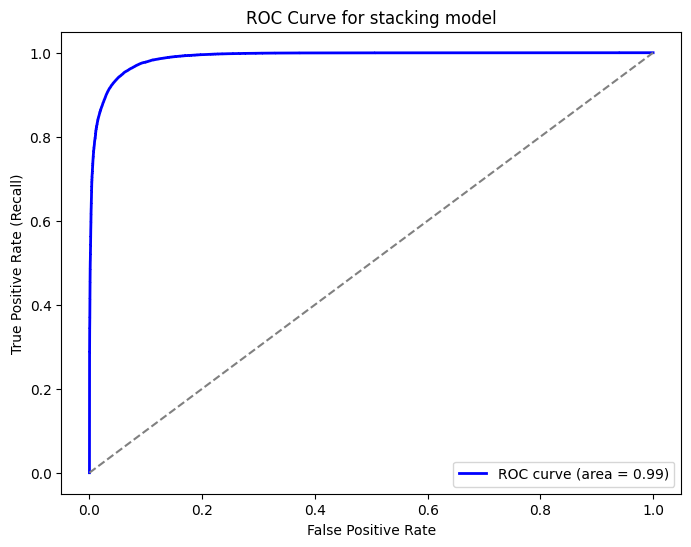

Area Under the ROC Curve (AUC): 0.99


In [ ]:
y_pred_prob_sk = stacking_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sk)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for stacking model')
plt.legend(loc='lower right')
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")

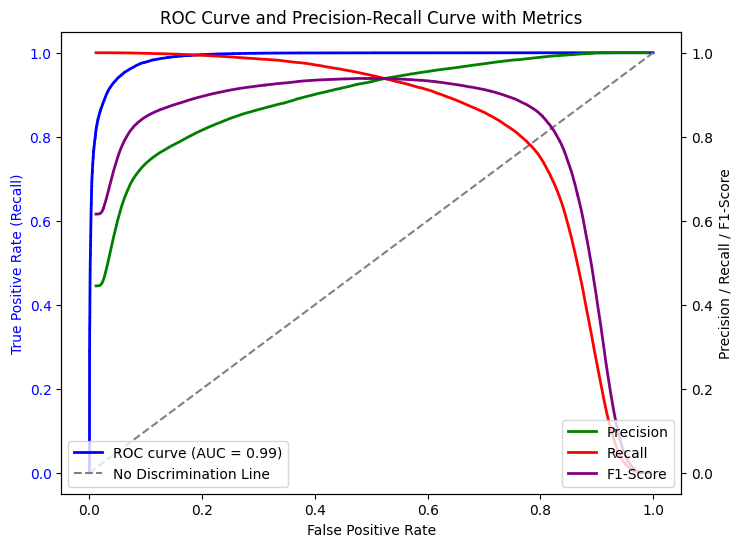

In [ ]:

y_pred_prob_sm = stacking_model.predict_proba(X_test)[:, 1]


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_sm)


f1_scores = 2 * (precision * recall) / (precision + recall)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()

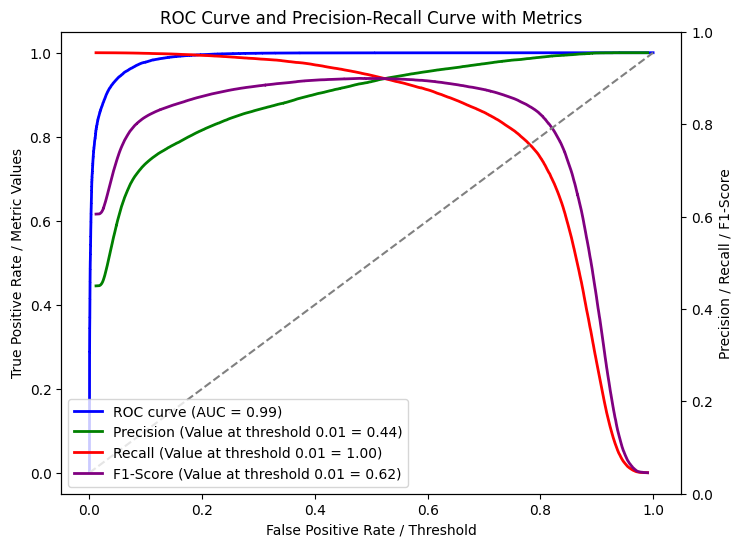

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_sm = stacking_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_sm)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## stacking with XGB

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
best_rf = random_search_rf.best_estimator_
best_svm = random_search_svm.best_estimator_
best_adaboost = random_search_adaboost.best_estimator_
best_knn = random_search_knn.best_estimator_
best_lr = random_search_lr.best_estimator_  
best_xgb = random_search_xgb.best_estimator_# final estimator


In [ ]:
base_learners = [
     ('rf', best_rf),
     ('svm', best_svm),
    ('adaboost', best_adaboost),
    ('knn', best_knn),
     ('Lr',best_rf)
]

In [ ]:
meta_learner = best_xgb
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

In [ ]:

start_time = time.time()
stacking_model.fit(X_train, y_train)
end_time = time.time()
runtime = end_time - start_time
print(f"Stacking model training time: {runtime:.2f} seconds")

Stacking model training time: 741.62 seconds


In [ ]:
# Make predictions
y_pred_stack = stacking_model.predict(X_test)

# Calculate accuracy and print the classification report
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print("Accuracy: {:.2f}%".format(accuracy_stack * 100))
print(classification_report(y_test, y_pred_stack))

Accuracy: 94.00%
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     56578
           1       0.92      0.94      0.93     45339

    accuracy                           0.94    101917
   macro avg       0.94      0.94      0.94    101917
weighted avg       0.94      0.94      0.94    101917



In [21]:
performance = {}
performance['RF'] = 0.8950
performance['SVM'] = 0.5930
performance['Adaboosting'] = 0.8049
performance['kNN'] = 0.8938
performance['Logistic Regression'] = 0.7424
performance['XGB'] =0.8800
performance['DT'] = 0.8339
performance['GNB'] = 0.7521
performance['GB'] = 0.9323
performance['Stacking'] = 0.94

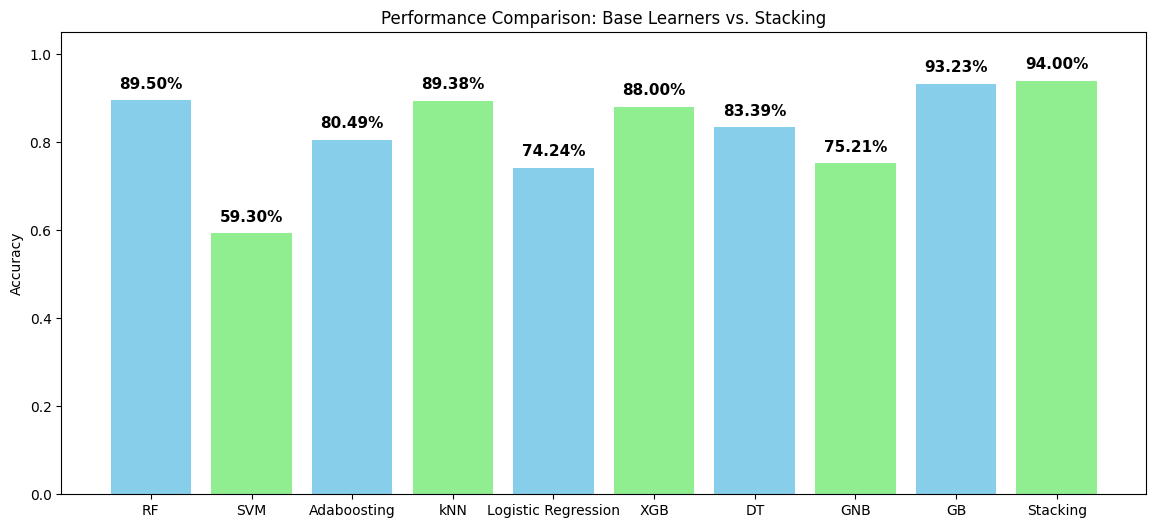

In [22]:

# If you only want to plot KNN and DT:
performance_filtered = {k: performance[k] for k in ['RF','SVM','Adaboosting','kNN', 'Logistic Regression','XGB','DT','GNB','GB', 'Stacking']}

plt.figure(figsize=(14, 6))
colors = ['skyblue', 'lightgreen']

# Create the bar chart
bars = plt.bar(performance_filtered.keys(), performance_filtered.values(), color=colors)

# Annotate each bar with its accuracy value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x-coordinate: center of the bar
        height + 0.02,                    # y-coordinate: slightly above the bar
        f"{height*100:.2f}%",             # Display accuracy as percentage
        ha='center',                      # Horizontal alignment
        va='bottom',                       # Vertical alignment
        fontsize=11,                       # Font size for clarity
        fontweight='bold'                  # Bold text
    )

plt.ylim([0, 1.05])  # Slightly above 1 for better visibility
plt.ylabel('Accuracy')
plt.title('Performance Comparison: Base Learners vs. Stacking')
plt.show()

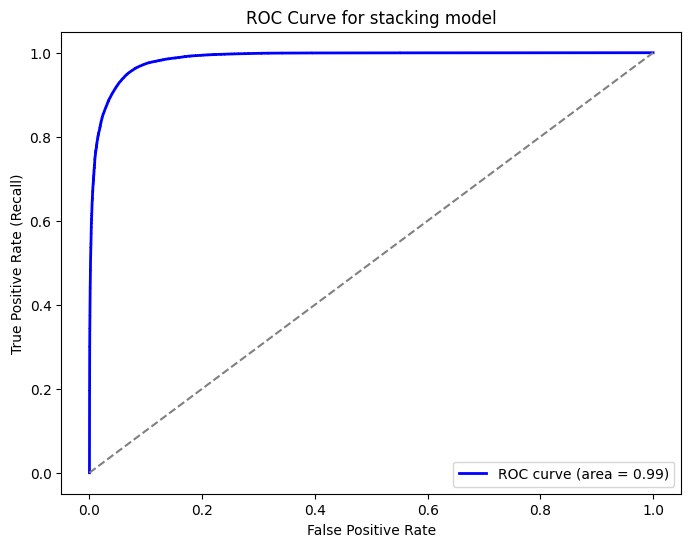

Area Under the ROC Curve (AUC): 0.99


In [ ]:
y_pred_prob_sk = stacking_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sk)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for stacking model')
plt.legend(loc='lower right')
plt.show()

print(f"Area Under the ROC Curve (AUC): {roc_auc:.2f}")

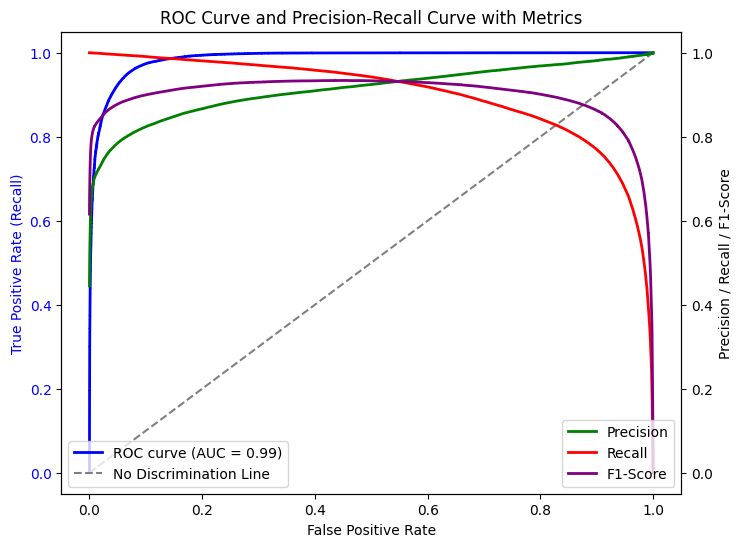

In [ ]:

y_pred_prob_sm = stacking_model.predict_proba(X_test)[:, 1]


fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = auc(fpr, tpr)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_sm)


f1_scores = 2 * (precision * recall) / (precision + recall)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve on the first y-axis
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

ax2 = ax1.twinx()
ax2.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')
ax2.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')
ax2.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Title
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Show plot
plt.show()

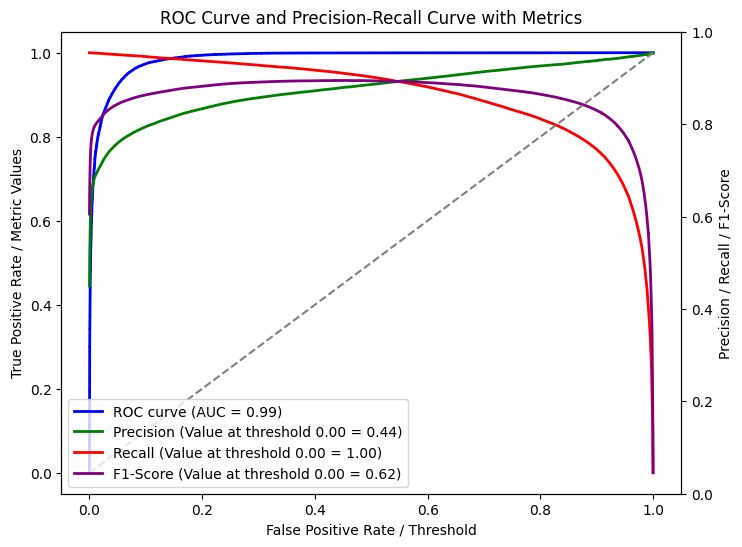

In [ ]:
# Predict probabilities for both ROC and Precision-Recall curves
y_pred_prob_sm = stacking_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob_sm)

# Calculate F1-Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Select a threshold value to display in the legend (e.g., 0.5)
threshold_index = 10  # Adjust this index to show the value at a specific threshold
threshold_value = pr_thresholds[threshold_index]

# Get corresponding precision, recall, and f1-score at the selected threshold
precision_value = precision[threshold_index]
recall_value = recall[threshold_index]
f1_score_value = f1_scores[threshold_index]

# # Plot both ROC curve and Precision-Recall curve in the same graph
# plt.figure(figsize=(8, 6))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot Precision line against Precision-Recall thresholds
plt.plot(pr_thresholds, precision[:-1], color='green', lw=2, label='Precision')

# Plot Recall line against Precision-Recall thresholds
plt.plot(pr_thresholds, recall[:-1], color='red', lw=2, label='Recall')

# Plot F1-Score line against Precision-Recall thresholds
plt.plot(pr_thresholds, f1_scores[:-1], color='purple', lw=2, label='F1-Score')

# Plot the dashed diagonal line (line of no discrimination)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Discrimination Line')

# Add dynamic values to the legend for Precision, Recall, and F1-Score
plt.legend(loc='lower left', labels=[
    f'ROC curve (AUC = {roc_auc:.2f})',
    f'Precision (Value at threshold {threshold_value:.2f} = {precision_value:.2f})',
    f'Recall (Value at threshold {threshold_value:.2f} = {recall_value:.2f})',
    f'F1-Score (Value at threshold {threshold_value:.2f} = {f1_score_value:.2f})'
    #  f'Threshold line = {threshold_value:.2f}',
    # 'No Discrimination Line'
])

# Labels and title
plt.xlabel('False Positive Rate / Threshold')
plt.ylabel('True Positive Rate / Metric Values')
plt.title('ROC Curve and Precision-Recall Curve with Metrics')

# Add a second y-axis for Precision, Recall, and F1-Score
ax2 = ax1.twinx()
ax2.set_ylabel('Precision / Recall / F1-Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Show plot
plt.show()


## Accuracy

In [ ]:
data = {
    'Model': ['Random Forest', 'SVM', 'Gaussian Naive Bayes', 'Logistic Regression', 'Decision Tree', 'AdaBoost', 'KNN', 'XGB','Gradient Boosting'],
    'Accuracy': [accuracy_rf*100, accuracy_svm*100, accuracy_gnb*100, accuracy_lr*100, accuracy_dtree*100, accuracy_adaboost*100, accuracy_KNN*100, accuracy_xgb*100,accuracy_gb*100]
}

df = pd.DataFrame(data)
df

,Model,Accuracy
0,Random Forest,89.495374
1,SVM,59.301196
2,Gaussian Naive Bayes,75.213164
3,Logistic Regression,74.280051
4,Decision Tree,83.098011
5,AdaBoost,81.841106
6,KNN,87.229805
7,XGB,90.639442
8,Gradient Boosting,93.229785


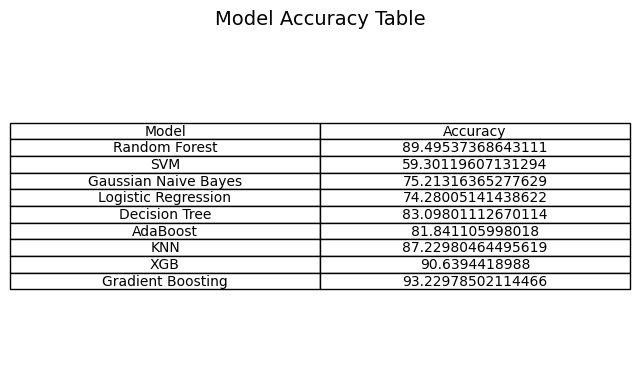

In [ ]:
# Data for the table
data = {
    'Model': ['Random Forest', 'SVM', 'Gaussian Naive Bayes', 'Logistic Regression', 'Decision Tree', 'AdaBoost', 'KNN', 'XGB','Gradient Boosting'],
    'Accuracy': [accuracy_rf*100, accuracy_svm*100, accuracy_gnb*100, accuracy_lr*100, accuracy_dtree*100, accuracy_adaboost*100, accuracy_KNN*100, accuracy_xgb*100,accuracy_gb*100]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
col_labels = [r"\textbf{" + col + "}" for col in df.columns]  # Use LaTeX for bold
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Set the figure title
plt.title("Model Accuracy Table", fontsize=14, pad=20)

# Show the plot
plt.show()

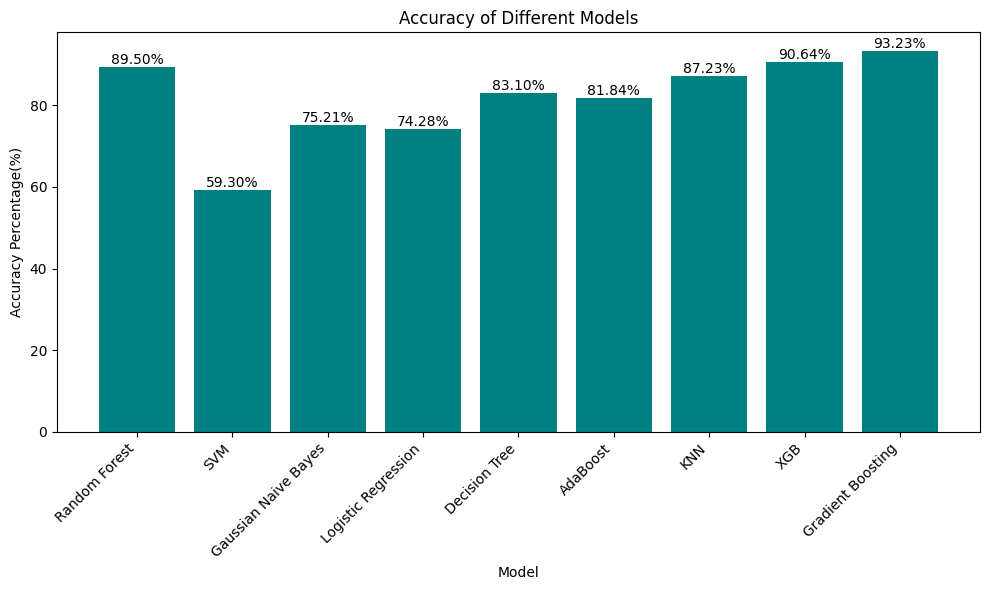

In [ ]:
data = {
    'Model': ['Random Forest', 'SVM', 'Gaussian Naive Bayes', 'Logistic Regression', 'Decision Tree', 'AdaBoost', 'KNN', 'XGB','Gradient Boosting'],
    'Accuracy': [accuracy_rf*100, accuracy_svm*100, accuracy_gnb*100, accuracy_lr*100, accuracy_dtree*100, accuracy_adaboost*100, accuracy_KNN*100, accuracy_xgb*100,accuracy_gb*100]
}



# Create a DataFrame
df = pd.DataFrame(data)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['Accuracy'], color='Teal')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add accuracy values above each bar
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate of text
        bar.get_height(),                  # y-coordinate of text
        f'{bar.get_height():.2f}%',         # Text to display (formatted to 2 decimals)
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Add labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy Percentage(%)")
plt.title("Accuracy of Different Models")

# Show the plot
plt.tight_layout()
plt.show()